<center> <img src="https://miro.medium.com/v2/resize:fit:1250/format:webp/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width=25% > </center>

<br><br>

<center> 
    <font size="6">Final Lab (Part 1): Keypoint Detection, Bag of Visual Words and Image Classification</font>
</center>
<center> 
    <font size="4">Computer Vision 1 University of Amsterdam</font> 
</center>
<center> 
    <font size="4">Due 23:59PM, October 18, 2024 (Amsterdam time)</font> 
</center>
<center> 
    <font size="4"><b>TA's: Vlad, Matey & Antonios</b></font>
</center>

<br><br>

***

<br><br>

<center>

Student1 ID: 13426192\
Student1 Name: Emma Kasteleyn

Student2 ID: 15552055\
Student2 Name: Platon Karageorgis

Student3 ID: 13854577\
Student3 Name: Jasper van der Valk

</center>

### **General Guidelines**

Your code must be handed in this Jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Final Lab (Part 1) Assignment. Please also fill out your names and IDs above.

For full credit, make sure your notebook follows these guidelines:

- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Understand the problem as much as you can. When answering a question, provide evidence (qualitative and/or quantitative results, references to papers, figures, etc.) to support your arguments. Not everything might be explicitly asked for, so think about what might strengthen your arguments to make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Add a number, a title, and, if applicable, the name and unit of variables in a table, and name and unit of axes and legends in a figure.

**Late submissions are not allowed.** Assignments submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance to avoid last-minute system failure issues.

**Environment:** Since this is a project-based assignment, you are free to use any feature descriptor and machine learning tools (e.g., K-means, SVM). You should use Python for your implementation. You are free to use any Python library for this assignment, but make sure to provide a conda environment file!

**Plagiarism Note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious offense and any misconduct will be addressed according to university regulations. This includes using generative tools such as ChatGPT.

**Ensure that you save all results/answers to the questions (even if you reuse some code).**

### **Report Preparation**

Your tasks include the following:

1. **Report Preparation:** For both parts of the final project, students are expected to prepare a report. The report should include all details on implementation approaches, analysis of results for different settings, and visualizations illustrating experiments and performance of your implementation. Grading will be based on the report, so it should be as self-contained as possible. If the report contains faulty results or ambiguities, TAs can refer to your code for clarification. Only section 10 of this notebook should **not** be included in the report.

2. **Explanation of Results:** Do not just provide numbers without explanation. Discuss different settings to show your understanding of the material and processes involved.

3. **Quantitative Evaluation:** For quantitative evaluation, you are expected to provide the results based on the mAP (mean Average Precision) metric. You should report the mAP for each experimental setup. 

4. **Qualitative Evaluation:** For qualitative evaluation, you are expected to visualize the top-5 and bottom-5 ranked test images (based on classifier confidence for the target class) per setup. Provide a figure for each experimental setup Visual elements such as charts, graphs, and plots are always useful. Keep this in mind while writing your reports.

5. **Aim:** Understand the basic Image Classification pipeline using a traditional Bag of Visual Words method.

6. **Working on Assignments:** Students should work in assigned groups for **two** weeks. Any questions can be discussed on ED.

    - **Submission:** Submit your source code and report together in a zip file (`ID1_ID2_ID3_part1.zip`). The report should be a maximum of 10 pages (single-column, including tables and figures, excluding references and appendix). Express thoughts concisely. Tables and figures must be accompanied by a description. Number them and, if applicable, name variables in tables, and label axes in figures.

7. **Hyperparameter Search:** In your experiments, remember to perform a hyperparameter search to find the optimal settings for your classifier. Clearly document the search process, the parameters you explored, and how they influenced the performance of your model.

8. **Format and Testing:** The report should be in **PDF format**, and the code in **.ipynb format**. Test that all functionality works as expected in the notebook.

### **Overview**

- [Section 1: Data Preparation (0 points)](#section-1)
- [Section 2: Keypoint Detection and Feature Extraction (3 points)](#section-2)
- [Section 3: Building the Visual Vocabulary (3 points)](#section-3)
- [Section 4: Encoding Train Image Features (3 points)](#section-4)
- [Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)](#section-5)
- [Section 6: Encoding Test Image Features (0 points)](#section-6)
- [Section 7: Training the Classifiers (5 points)](#section-7)
- [Section 8: Evaluating the Classifiers (12 points)](#section-8)
- [Section 9: Hyperparameter Search (16 points)](#section-9)
- [Section 10: Using CLIP for Image Classification (5 points)](#section-10)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

### **Section 1: Data Preparation (0 points)**

The goal of this lab is to implement an image classification system that can identify objects from a given set of classes. You will perform a 5-class image classification using a bag-of-words approach ([reference](http://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf)). The classes for this task are:

1. **Frog**
2. **Automobile**
3. **Bird**
4. **Cat**
5. **Deer**

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) will be used for this task. This dataset contains 32x32 pixel RGB images, divided into sub-directories with 5000 training images and 1000 test images for each class.

The dataset will be automatically downloaded using the code provided in this notebook. You will need to perform training on the training set, which will later be divided into two subsets: one for building the visual vocabulary and another for training the classifier. Using more samples for training generally results in better performance. However, if computational resources are limited, you may use fewer training images to save time, as long as at least 500 images per class are included.

The system must be tested using the specified subset of test images. Use all 1000 test images (per class) to observe the full performance of the model. Ensure that test images are excluded from training to maintain a fair comparison.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2

print(torch.__version__)
print()

total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

2.2.0+cu118
Files already downloaded and verified
Files already downloaded and verified
Filtered train data: torch.Size([5000, 32, 32, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([1000, 32, 32, 3])
Filtered test labels: torch.Size([1000])


<a id="section-2"></a>
### **Section 2: Keypoint Detection and Feature Extraction (3 points)**

In this section, you will work on detecting keypoints and extracting features from the dataset. Your task is to use **two different feature extraction techniques** to identify keypoints in the images. Visualize two images from each of the five classes (Frog, Automobile, Bird, Cat, Deer) for both feature extraction techniques. For each image, draw circles around the detected keypoints that represent their size.

This step is essential to understand how different feature extractors behave across various classes, setting the foundation for further analysis and classification in later steps.

**Hint:** You can use the OpenCV library to detect keypoints and extract features. You can also upscale the images to improve the visualization of the keypoints.

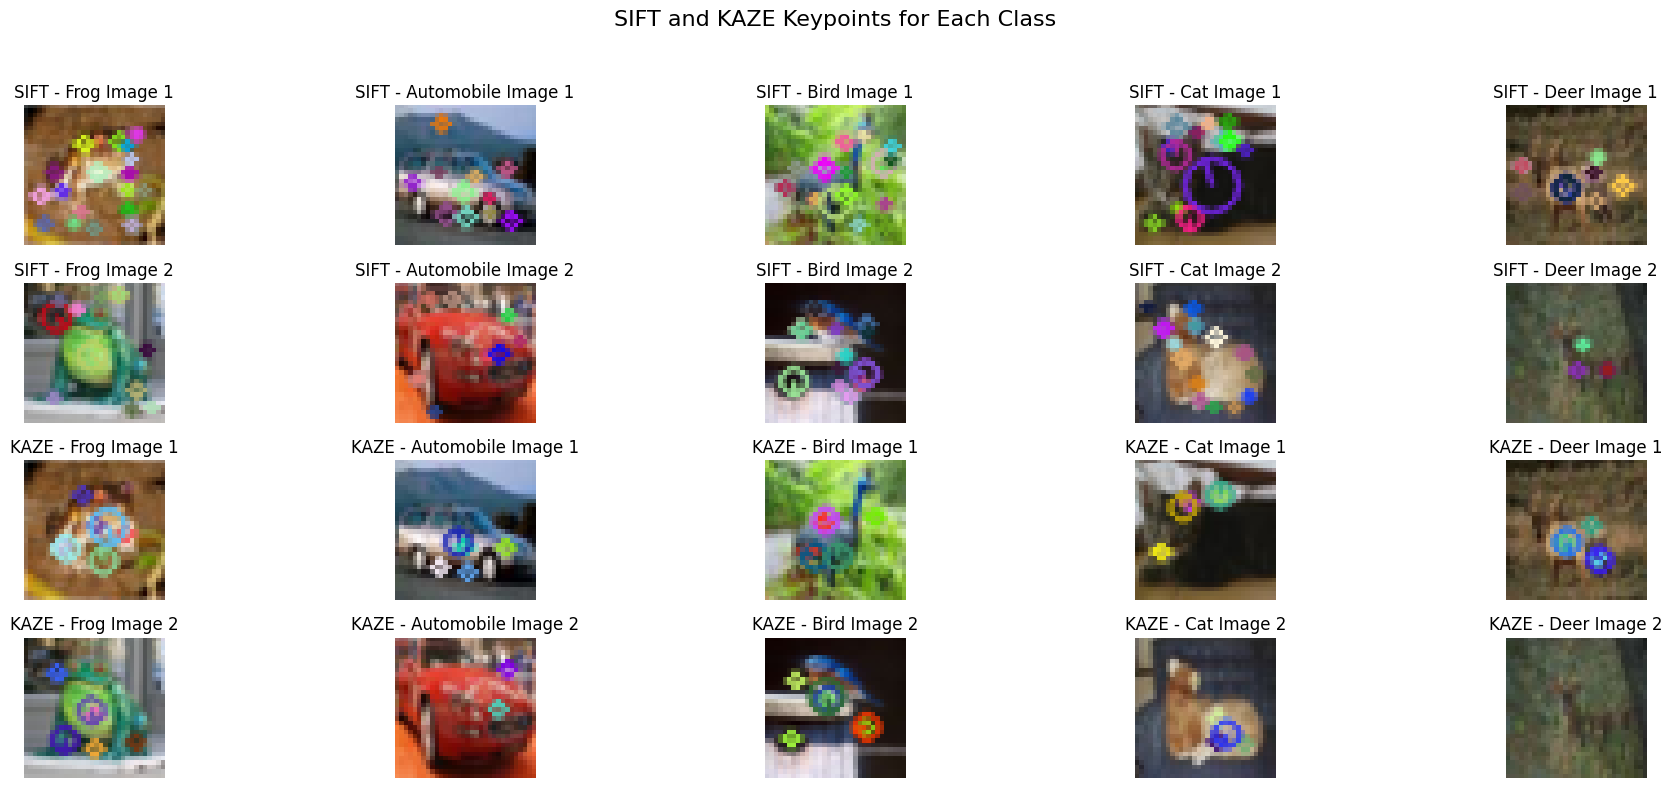

In [19]:
def feature_extraction_sift(img,num_keypoints=None, num_octave_layers=None):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures=num_keypoints, nOctaveLayers=num_octave_layers)
    kp, des = sift.detectAndCompute(gray,None)
    return kp, des

def feature_extraction_kaze(img, threshold=None):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if threshold is None:
        threshold = 0.001
    alg = cv2.KAZE_create(threshold=threshold)
    kps, dsc = alg.detectAndCompute(gray, None)
    return kps, dsc


def visualize_keypoints_subplots(ax, img, keypoints, title):
    # Draw keypoints on the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_with_keypoints  = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_with_keypoints_rgb  = cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)
    
    ax.imshow(img_with_keypoints_rgb)
    ax.set_title(title)
    ax.axis('off')

def visualize_for_classes(images, labels, class_names):
    class_name_to_label = {'Frog': 0, 'Automobile': 1, 'Bird': 2, 'Cat': 3, 'Deer': 4}
    fig, axes = plt.subplots(4, 5, figsize=(20, 8))
    fig.suptitle('SIFT and KAZE Keypoints for Each Class', fontsize=16)
    for class_name in class_names:
        class_label = class_name_to_label[class_name]
        class_images = [img for img, label in zip(images, labels) if label == class_label][:2]
        for i, img in enumerate(class_images):
            img=np.array((img+1)*127.5).astype(np.uint8)
            kp_sift, _ = feature_extraction_sift(img)
            visualize_keypoints_subplots(axes[0+i,class_label],img, kp_sift, f'SIFT - {class_name} Image {i + 1}')
            kp_kaze, _ = feature_extraction_kaze(img)
            visualize_keypoints_subplots(axes[2+i,class_label],img, kp_kaze, f'KAZE - {class_name} Image {i + 1}')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

class_names = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']
visualize_for_classes(train_images, train_labels, class_names)

<a id="section-3"></a>
### **Section 3: Building the Visual Vocabulary (3 points)**

In this section, the task is to create a visual vocabulary by clustering feature descriptors extracted from the images using K-Means. Each cluster center in this vocabulary will represent a visual word. Use the two different extraction techniques you implemented to extract descriptors from a subset of training images that includes all categories, and then apply K-Means clustering to build the vocabulary. The number of clusters is fixed at 1000, but you can experiment with different values when you are tuning the hyperparameters in section 9.

To examine the effect of different amounts of training data, build separate visual vocabularies using 30%, 40%, and 50% subsets of the training images. For faster clustering, the `faiss` library can be used, as it provides an efficient implementation of K-Means. Then, visualize the first 10 clusters for each feature extraction technique and each subset size using PCA to reduce the dimensions to 2D.

**Hints:**
1. Begin by debugging the code with a small number of input images to ensure it functions correctly before running it on larger datasets.
2. If the `faiss` library is not available, K-Means clustering can also be performed using the `sklearn` or `scipy` libraries.
3. For visualization, use PCA from `sklearn.decomposition` to reduce the high-dimensional descriptors to 2D. Display up to 10 clusters in the scatter plot to maintain clarity.

### Visualize with Faiss

In [20]:
# DONT CHANGE THE ! TO % BECAUSE CHAOS WILL HAPPEN FAISS IS SH*T
!pip install faiss-cpu
import faiss
from sklearn.decomposition import PCA
import random

## Faiss Plot Doesn't work, Use Sk-learn (we still implement this because the whole implementation below was based on Faiss)

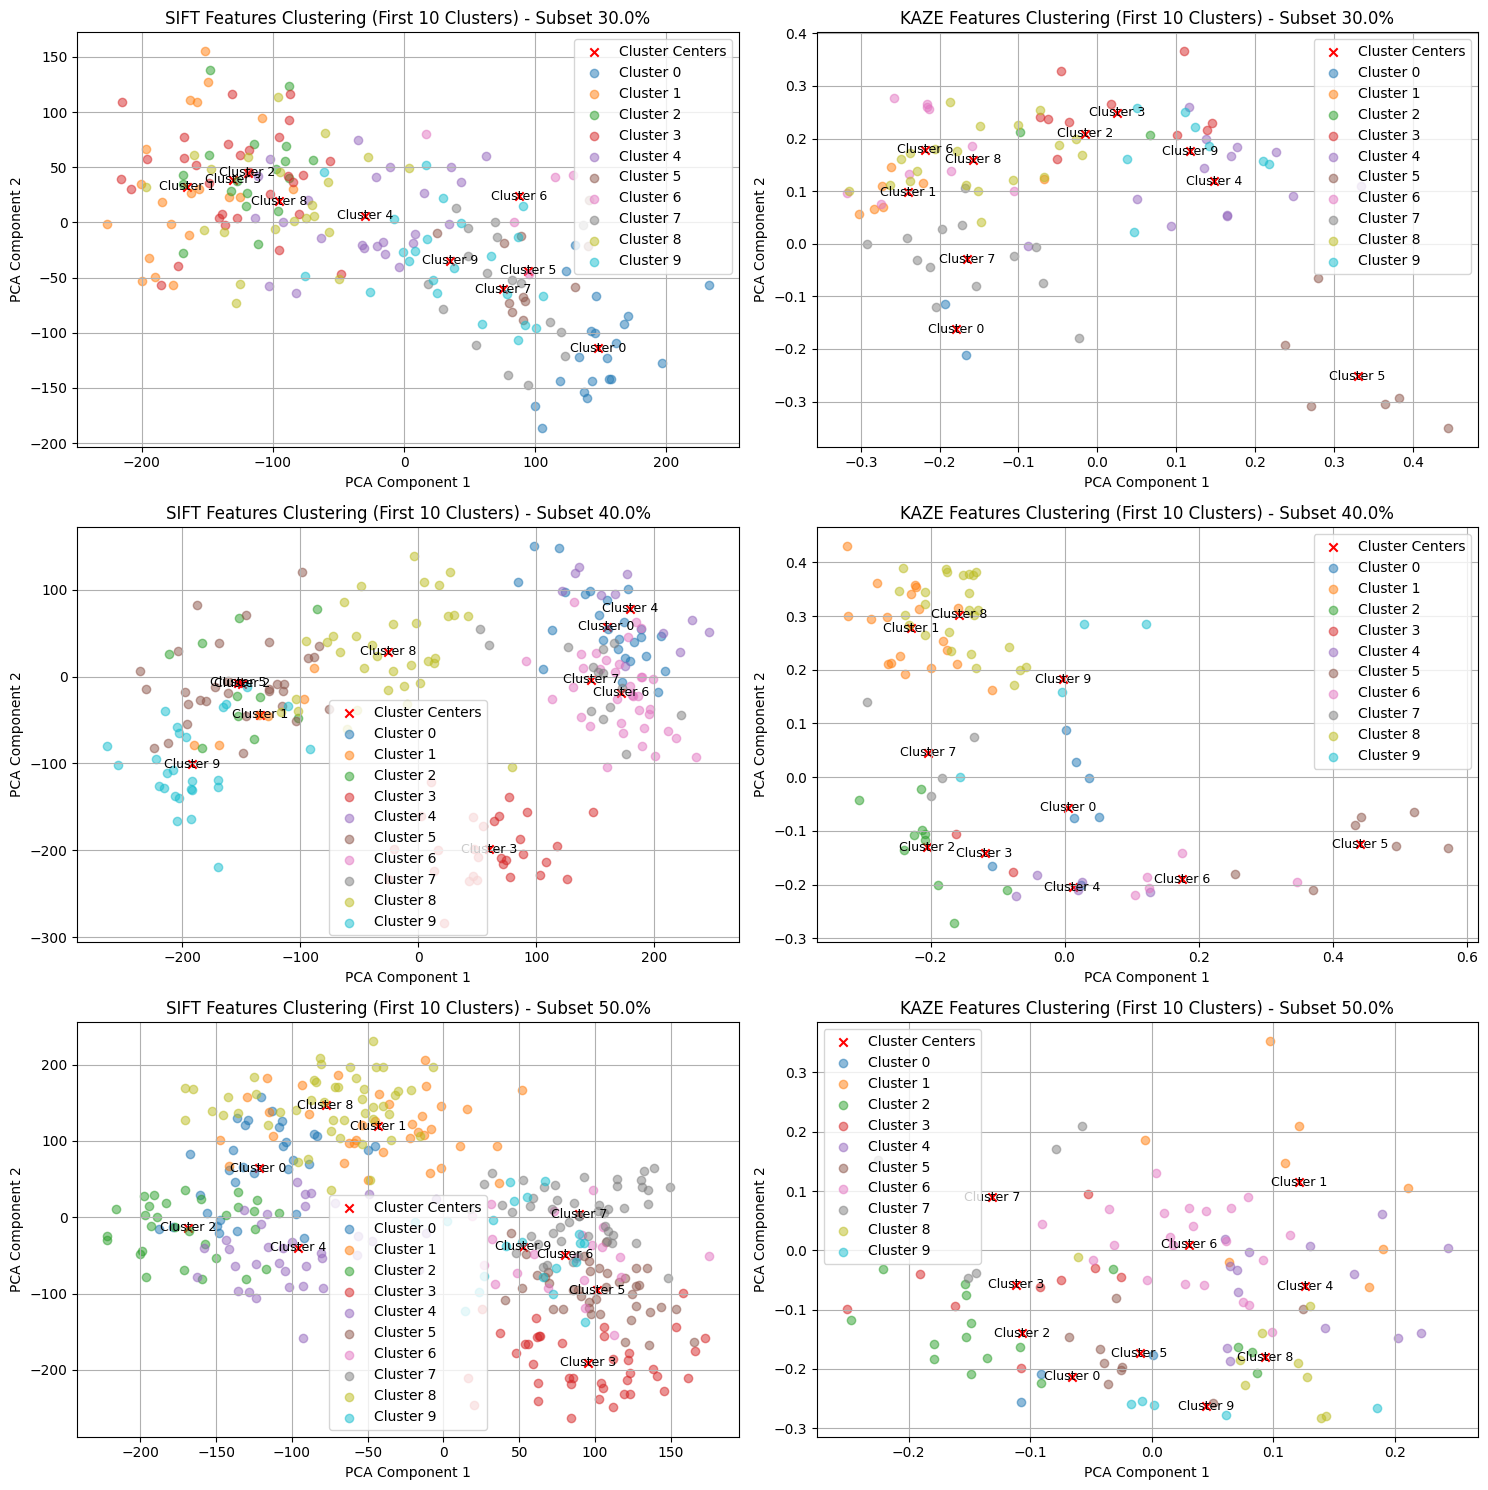

In [21]:
def extract_descriptors(images, selected_labels, method='sift', num_keypoints=None, num_octave_layers=None, threshold=None):
    descriptors = []
    valid_labels = []
    for i, img in enumerate(images):
        img = np.array((img + 1) * 127.5).astype(np.uint8)
        if method == 'sift':
            _, des = feature_extraction_sift(img, num_keypoints, num_octave_layers)
        elif method == 'kaze':
            _, des = feature_extraction_kaze(img, threshold)
        if des is not None and des.size > 0:
            descriptors.append(des)
            valid_labels.append(selected_labels[i])
            
    return descriptors, valid_labels
        

def build_visual_vocabulary(descriptors, num_clusters):
    valid_descriptors = [des for des in descriptors if des is not None and len(des) > 0]
    dims = [des.shape[1] for des in valid_descriptors]
    if len(set(dims)) != 1:
        print("Descriptors have varying dimensions:", set(dims))
        expected_dim = max(set(dims), key=dims.count)  # Most common dimension
        valid_descriptors = [des for des in valid_descriptors if des.shape[1] == expected_dim]
    descriptors_stacked = np.vstack(valid_descriptors)
    d = descriptors_stacked.shape[1]
    kmeans = faiss.Kmeans(d, num_clusters, niter=50, nredo=5, verbose=True)
    kmeans.train(descriptors_stacked.astype('float32'))
    return kmeans

def visualize_clusters(ax, kmeans, descriptors, method="sift", subset_percentage=None):
    descriptors_stacked = np.vstack([des for des in descriptors if des is not None and len(des) > 0])
    cluster_centers = kmeans.centroids

    # Fit PCA on both descriptors and cluster centers
    all_data = np.vstack([descriptors_stacked, cluster_centers])
    pca = PCA(n_components=2)
    pca.fit(all_data)
    reduced_descriptors = pca.transform(descriptors_stacked)
    reduced_centers = pca.transform(cluster_centers)
    
    # Assign descriptors to clusters
    index = faiss.IndexFlatL2(cluster_centers.shape[1]) 
    index.add(cluster_centers)
    _, cluster_indices = index.search(descriptors_stacked.astype(np.float32), 1)

    # Plot
    ax.scatter(reduced_centers[:10, 0], reduced_centers[:10, 1], marker='x', c='red', label='Cluster Centers')

    for i in range(10):
        cluster_mask = cluster_indices.flatten() == i
        cluster_descriptors = reduced_descriptors[cluster_mask]
        if cluster_descriptors.shape[0] > 0:
            ax.scatter(cluster_descriptors[:, 0], cluster_descriptors[:, 1], alpha=0.5, label=f'Cluster {i}')
            ax.text(reduced_centers[i, 0], reduced_centers[i, 1], f'Cluster {i}', fontsize=9, color='black', ha='center', va='center')

    if subset_percentage is not None:
        ax.set_title(f'{method.upper()} Features Clustering (First 10 Clusters) - Subset {subset_percentage*100:.1f}%')
    else:
        ax.set_title(f'Visualization of Visual Vocabulary Clusters ({method.upper()})')

    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()
    ax.grid()

subset_ratios = [0.3, 0.4, 0.5]  # 30%, 40%, 50%
num_clusters = 1000
num_images_to_use = [0, 0, 0]
kmeans_sift = {}
kmeans_kaze = {}
sift_descriptors = {}
valid_labels_sift = {}
kaze_descriptors = {}
valid_labels_kaze = {}

fig, axes = plt.subplots(len(subset_ratios), 2, figsize=(15, 5 * len(subset_ratios)))

for i, ratio in enumerate(subset_ratios):
    num_images_to_use[i] = int(len(train_images) * ratio)
    selected_images = [img.numpy() for img in train_images[:num_images_to_use[i]]]
    selected_labels = train_labels[:num_images_to_use[i]]

    # SIFT
    sift_descriptors[i], valid_labels_sift[i] = extract_descriptors(
        selected_images, selected_labels, method='sift')
    kmeans_sift[i] = build_visual_vocabulary(sift_descriptors[i], num_clusters)
    visualize_clusters(axes[i, 0], kmeans_sift[i], sift_descriptors[i], method="sift", subset_percentage=ratio)

    # KAZE
    kaze_descriptors[i], valid_labels_kaze[i] = extract_descriptors(
        selected_images, selected_labels, method='kaze')
    kmeans_kaze[i] = build_visual_vocabulary(kaze_descriptors[i], num_clusters)
    visualize_clusters(axes[i, 1], kmeans_kaze[i], kaze_descriptors[i], method="kaze", subset_percentage=ratio)

plt.tight_layout()
plt.show()


### Visualize with Sk-learn

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

C:\Users\emmak\AppData\Local\Temp\ipykernel_16304\2284088449.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", 10)


Using 300 images per class for training subset.
Using 1500 images for training subset.
Using 3500 images for remaining subset.
Fitting KMeans with 1000 clusters on 49901 features.
Initialization complete


d:\Emma\Overig\Python\envs\cv1_group4\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Iteration 0, inertia 5070433280.0.
Iteration 1, inertia 3697670656.0.
Iteration 2, inertia 3617893120.0.
Iteration 3, inertia 3585318912.0.
Iteration 4, inertia 3566655488.0.
Iteration 5, inertia 3554580992.0.
Iteration 6, inertia 3546364672.0.
Iteration 7, inertia 3540498944.0.
Iteration 8, inertia 3536080640.0.
Iteration 9, inertia 3532718336.0.
Iteration 10, inertia 3529921536.0.
Iteration 11, inertia 3527741184.0.
Iteration 12, inertia 3525850624.0.
Iteration 13, inertia 3524411904.0.
Iteration 14, inertia 3523384320.0.
Iteration 15, inertia 3522652160.0.
Iteration 16, inertia 3522069248.0.
Iteration 17, inertia 3521547776.0.
Iteration 18, inertia 3521093632.0.
Iteration 19, inertia 3520779776.0.
Iteration 20, inertia 3520518912.0.
Iteration 21, inertia 3520288512.0.
Iteration 22, inertia 3520133632.0.
Iteration 23, inertia 3519991040.0.
Iteration 24, inertia 3519872000.0.
Iteration 25, inertia 3519756544.0.
Iteration 26, inertia 3519642624.0.
Iteration 27, inertia 3519529216.0.
It

C:\Users\emmak\AppData\Local\Temp\ipykernel_16304\2284088449.py:128: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes_sift.scatter(
C:\Users\emmak\AppData\Local\Temp\ipykernel_16304\2284088449.py:160: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes_kaze.scatter(


Using 400 images per class for training subset.
Using 2000 images for training subset.
Using 3000 images for remaining subset.
Fitting KMeans with 1000 clusters on 65791 features.
Initialization complete
Iteration 0, inertia 6725641216.0.
Iteration 1, inertia 4919981568.0.
Iteration 2, inertia 4815463424.0.
Iteration 3, inertia 4771030528.0.
Iteration 4, inertia 4746280448.0.
Iteration 5, inertia 4729717248.0.
Iteration 6, inertia 4717764096.0.
Iteration 7, inertia 4709587968.0.
Iteration 8, inertia 4703679488.0.
Iteration 9, inertia 4699058176.0.
Iteration 10, inertia 4695485440.0.
Iteration 11, inertia 4692549120.0.
Iteration 12, inertia 4690043904.0.
Iteration 13, inertia 4687884800.0.
Iteration 14, inertia 4685983744.0.
Iteration 15, inertia 4684472832.0.
Iteration 16, inertia 4683235328.0.
Iteration 17, inertia 4682212864.0.
Iteration 18, inertia 4681336832.0.
Iteration 19, inertia 4680516608.0.
Iteration 20, inertia 4679880704.0.
Iteration 21, inertia 4679259648.0.
Iteration 22, 

C:\Users\emmak\AppData\Local\Temp\ipykernel_16304\2284088449.py:128: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes_sift.scatter(
C:\Users\emmak\AppData\Local\Temp\ipykernel_16304\2284088449.py:160: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes_kaze.scatter(


Using 500 images per class for training subset.
Using 2500 images for training subset.
Using 2500 images for remaining subset.
Fitting KMeans with 1000 clusters on 82969 features.
Initialization complete
Iteration 0, inertia 8516762624.0.
Iteration 1, inertia 6231997952.0.
Iteration 2, inertia 6106499072.0.
Iteration 3, inertia 6053314048.0.
Iteration 4, inertia 6021837312.0.
Iteration 5, inertia 6000172544.0.
Iteration 6, inertia 5984896512.0.
Iteration 7, inertia 5973330944.0.
Iteration 8, inertia 5964590080.0.
Iteration 9, inertia 5957698048.0.
Iteration 10, inertia 5951790080.0.
Iteration 11, inertia 5946907136.0.
Iteration 12, inertia 5943000064.0.
Iteration 13, inertia 5939542016.0.
Iteration 14, inertia 5936833024.0.
Iteration 15, inertia 5934608384.0.
Iteration 16, inertia 5932627968.0.
Iteration 17, inertia 5930990080.0.
Iteration 18, inertia 5929402368.0.
Iteration 19, inertia 5927926272.0.
Iteration 20, inertia 5926711808.0.
Iteration 21, inertia 5925741568.0.
Iteration 22, 

C:\Users\emmak\AppData\Local\Temp\ipykernel_16304\2284088449.py:128: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes_sift.scatter(
C:\Users\emmak\AppData\Local\Temp\ipykernel_16304\2284088449.py:160: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes_kaze.scatter(


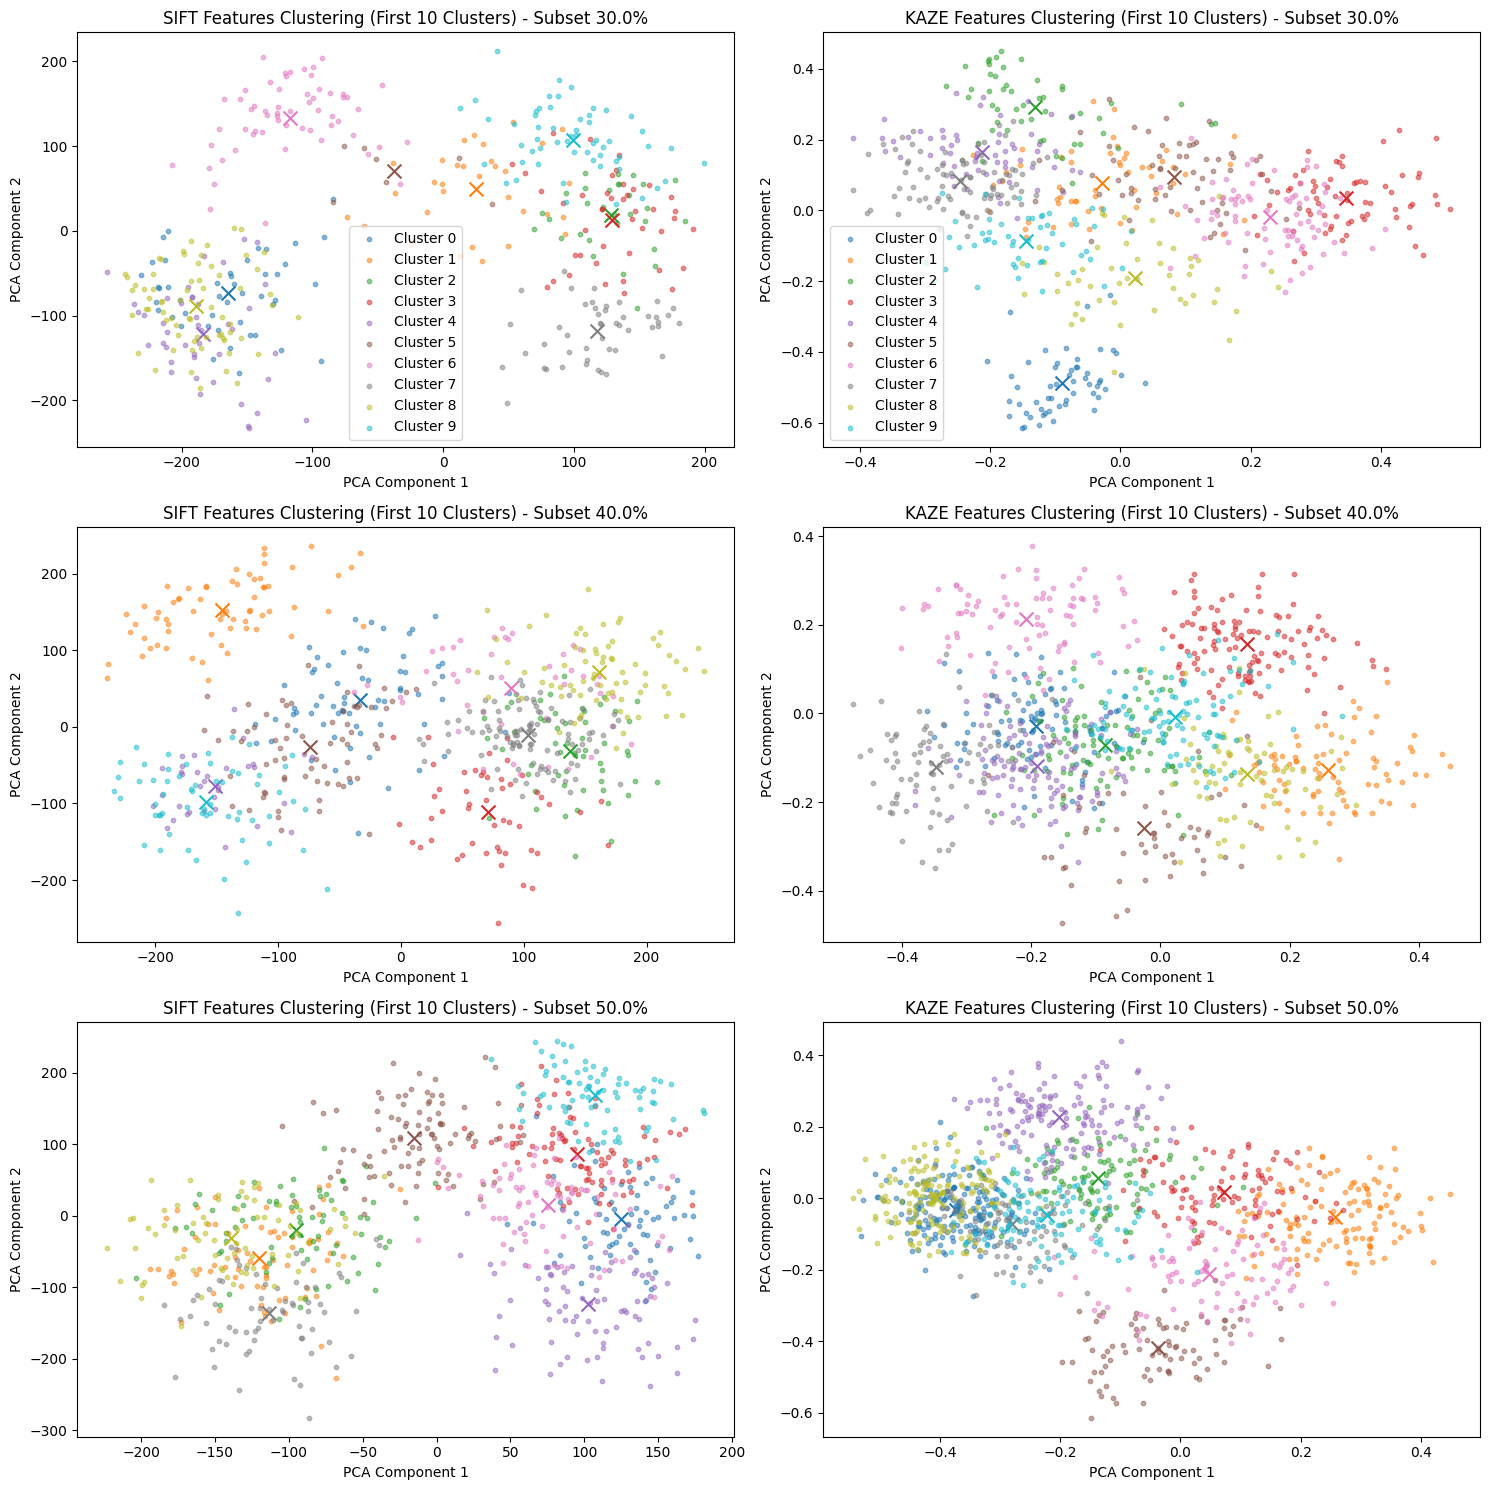

In [6]:
def build_visual_vocabulary_2(descriptors, num_clusters):
    descriptors_stacked = np.vstack([des for des in descriptors if des is not None])
    print(
        f"Fitting KMeans with {num_clusters} clusters on {descriptors_stacked.shape[0]} features."
    )
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, verbose=1)
    kmeans.fit(descriptors_stacked)
    print(f"KMeans fitted. Cluster centers shape: {kmeans.cluster_centers_.shape}")
    return kmeans


def get_subset_indices(
    labels, subset_percentage, num_classes, images_per_class_train, shuffle=True):
    assert 0 <= subset_percentage <= 1, "subset_percentage must be between 0 and 1."
    images_per_class_train_subset = int(images_per_class_train * subset_percentage)
    print(
        f"Using {images_per_class_train_subset} images per class for training subset."
    )

    voc_indices = []
    remaining_indices = []
    for class_idx in range(num_classes):
        class_indices = np.where(labels == class_idx)[0]
        if shuffle:
            np.random.shuffle(class_indices)
        voc_indices.extend(class_indices[:images_per_class_train_subset])
        remaining_indices.extend(class_indices[images_per_class_train_subset:])

    print(f"Using {len(voc_indices)} images for training subset.")
    print(f"Using {len(remaining_indices)} images for remaining subset.")

    return voc_indices, remaining_indices


def extract_descriptors_2(images, selected_labels, method='sift', num_keypoints=None, num_octave_layers=None, threshold=None, upscale_factor=1):
    descriptors = []
    valid_labels = []
    for i, img in enumerate(images):
        img = np.array((img+1)*127.5).astype(np.uint8)  # Convert from [-1,1] to [0,255]
        if upscale_factor != 1:
            img = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_LINEAR)
        if method == 'sift':
            _, des = feature_extraction_sift(img, num_keypoints, num_octave_layers)
        elif method == 'kaze':
            _, des = feature_extraction_kaze(img, threshold)
        if des is not None:
            descriptors.append(des)
            valid_labels.append(selected_labels[i])

    return descriptors, valid_labels

def reduce_to_2d(data):
    pca = PCA(n_components=2)
    return pca.fit_transform(data)

subset_percentages = [0.3, 0.4, 0.5]
num_clusters = 1000
colors = plt.cm.get_cmap("tab10", 10)

fig, axes = plt.subplots(len(subset_percentages), 2, figsize=(15, 5 * len(subset_percentages)))

for i, subset_percentage in enumerate(subset_percentages):

    voc_indices, train_indices = get_subset_indices(
        train_labels.numpy(),
        subset_percentage,
        num_classes,
        images_per_class_train,
        shuffle=True,
    )

    voc_images = train_images[voc_indices]
    voc_labels = train_labels[voc_indices]

    selected_images = [voc_images[j].numpy() for j in range(len(voc_images))]
    selected_labels = voc_labels.numpy()

    sift_descriptors_chunk2, valid_labels_sift_chunk2 = extract_descriptors_2(
        selected_images, selected_labels, method='sift', upscale_factor=4
    )
    kmeans_sift_chunk2 = build_visual_vocabulary_2(sift_descriptors_chunk2, num_clusters)
 
    voc_centroids_sift_chunk2 = kmeans_sift_chunk2.cluster_centers_


    kaze_descriptors_chunk2, valid_labels_kaze_chunk2 = extract_descriptors_2(
        selected_images, selected_labels, method='kaze', upscale_factor=4
    )
 
    kmeans_kaze_chunk2 = build_visual_vocabulary_2(kaze_descriptors_chunk2, num_clusters)
 
    voc_centroids_kaze_chunk2 = kmeans_kaze_chunk2.cluster_centers_


    sift_descriptors_stacked_chunk2 = np.vstack([des for des in sift_descriptors_chunk2 if des is not None])
    kaze_descriptors_stacked_chunk2 = np.vstack([des for des in kaze_descriptors_chunk2 if des is not None])

   
    sift_labels_chunk2 = kmeans_sift_chunk2.predict(sift_descriptors_stacked_chunk2)
    kaze_labels_chunk2 = kmeans_kaze_chunk2.predict(kaze_descriptors_stacked_chunk2)


    pca_sift_chunk2 = PCA(n_components=2)
    sift_features_2d_chunk2 = pca_sift_chunk2.fit_transform(sift_descriptors_stacked_chunk2)
    voc_centroids_sift_2d_chunk2 = pca_sift_chunk2.transform(voc_centroids_sift_chunk2)

    pca_kaze_chunk2 = PCA(n_components=2)
    kaze_features_2d_chunk2 = pca_kaze_chunk2.fit_transform(kaze_descriptors_stacked_chunk2)
    voc_centroids_kaze_2d_chunk2 = pca_kaze_chunk2.transform(voc_centroids_kaze_chunk2)


    axes_sift = axes[i, 0]
    for cluster_id in range(10):
        cluster_points = sift_features_2d_chunk2[sift_labels_chunk2 == cluster_id]
        cluster_center = voc_centroids_sift_2d_chunk2[cluster_id]

  
        axes_sift.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            color=colors(cluster_id),
            s=10,
            alpha=0.5,
            label=f"Cluster {cluster_id}" if i == 0 else "",
        )

  
        axes_sift.scatter(
            cluster_center[0],
            cluster_center[1],
            color=colors(cluster_id),
            edgecolor="black",
            marker="x",
            s=100,
        )

    axes_sift.set_title(
        f"SIFT Features Clustering (First 10 Clusters) - Subset {subset_percentage*100:.1f}%"
    )
    axes_sift.set_xlabel("PCA Component 1")
    axes_sift.set_ylabel("PCA Component 2")


    axes_kaze = axes[i, 1]
    for cluster_id in range(10):
        cluster_points = kaze_features_2d_chunk2[kaze_labels_chunk2 == cluster_id]
        cluster_center = voc_centroids_kaze_2d_chunk2[cluster_id]

 
        axes_kaze.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            color=colors(cluster_id),
            s=10,
            alpha=0.5,
            label=f"Cluster {cluster_id}" if i == 0 else "",
        )

 
        axes_kaze.scatter(
            cluster_center[0],
            cluster_center[1],
            color=colors(cluster_id),
            edgecolor="black",
            marker="x",
            s=100,
        )

    axes_kaze.set_title(
        f"KAZE Features Clustering (First 10 Clusters) - Subset {subset_percentage*100:.1f}%"
    )
    axes_kaze.set_xlabel("PCA Component 1")
    axes_kaze.set_ylabel("PCA Component 2")


axes[0, 0].legend()
axes[0, 1].legend()


plt.tight_layout()
plt.show()


<a id="section-4"></a>
### **Section 4: Encoding Train Image Features (3 points)**

In this section, the task is to encode image features using the visual vocabulary created earlier. Each image will be represented as a histogram of visual words, reflecting the frequency of each visual word in the image. This representation will allow for comparing images based on their visual content.

To encode an image, identify the nearest visual word (cluster center) for each feature descriptor extracted from the image. Construct a histogram that counts the occurrences of each visual word within the image. The final output will be a collection of histograms, one for each image, where each histogram serves as the feature representation of that image. Once again,  Use the two different extraction techniques you implemented to extract descriptors from the images. Then, encode the images using the visual vocabulary created in the previous step.

**Hint:** Utilize the `faiss` library for efficient nearest neighbor search when assigning each descriptor to the nearest cluster center in the visual dictionary. If `faiss` is not available, consider using other libraries, such as `scikit-learn`, for this step. Once the histograms are obtained, they will be used for further tasks, such as training a classifier. For now, perform the encoding only for the training set.

In [22]:
def encode_features(descriptors, kmeans_clusters, num_clusters):
    kmeans_clusters = kmeans_clusters.centroids
    index = faiss.IndexFlatL2(kmeans_clusters.shape[1]) 
    index.add(kmeans_clusters.astype(np.float32)) 

    histograms = []
    
    for des in descriptors:
        if des is None or len(des) == 0:
            histograms.append(np.zeros(num_clusters))
            continue
        
        _, indices = index.search(des.astype(np.float32), 1)
        
        histogram = np.zeros(num_clusters, dtype=np.float32)
        for idx in indices.flatten():
            histogram[idx] += 1
        histograms.append(histogram)
    return np.array(histograms)
sift_histograms = encode_features(sift_descriptors[2], kmeans_sift[2], num_clusters)

kaze_histograms = encode_features(kaze_descriptors[2], kmeans_kaze[2], num_clusters)


<a id="section-5"></a>
### **Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)**

In this section, the task is to visualize the Bag of Visual Words for each class using the histograms generated in the previous step. The goal is to plot the mean histogram of visual words for each class, showing the distribution of visual words across the different categories in the training set.

Use the two different extraction techniques you implemented for this visualization. For each technique, calculate the mean histogram for each class and create a bar plot to display these histograms. Ensure that the plots are labeled clearly with the class names and feature descriptor types.

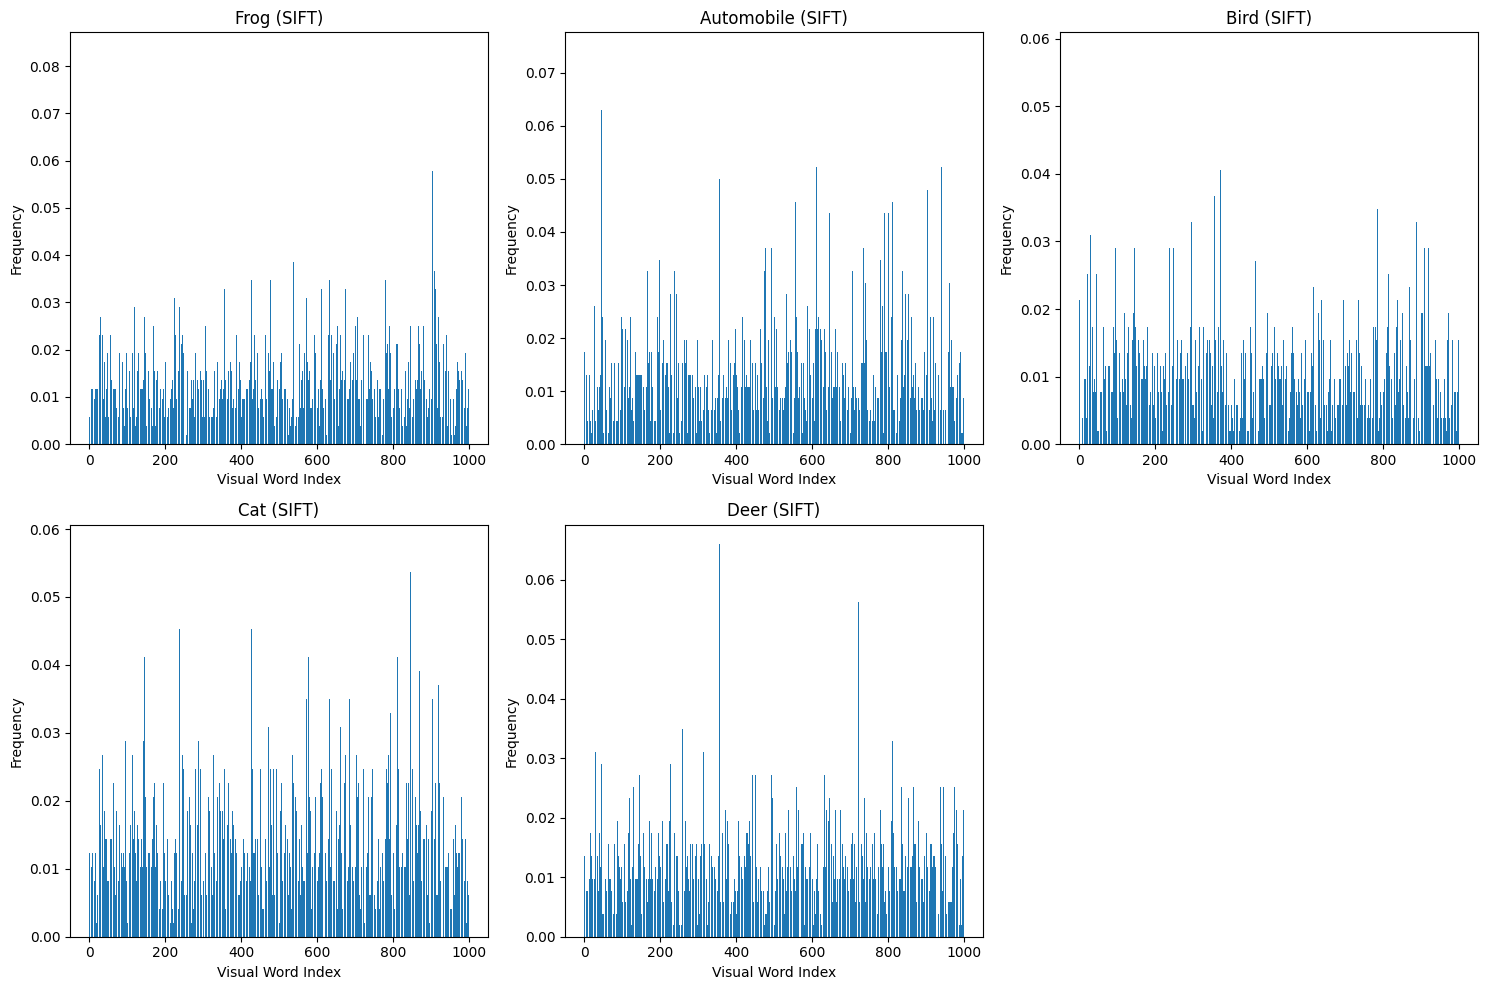

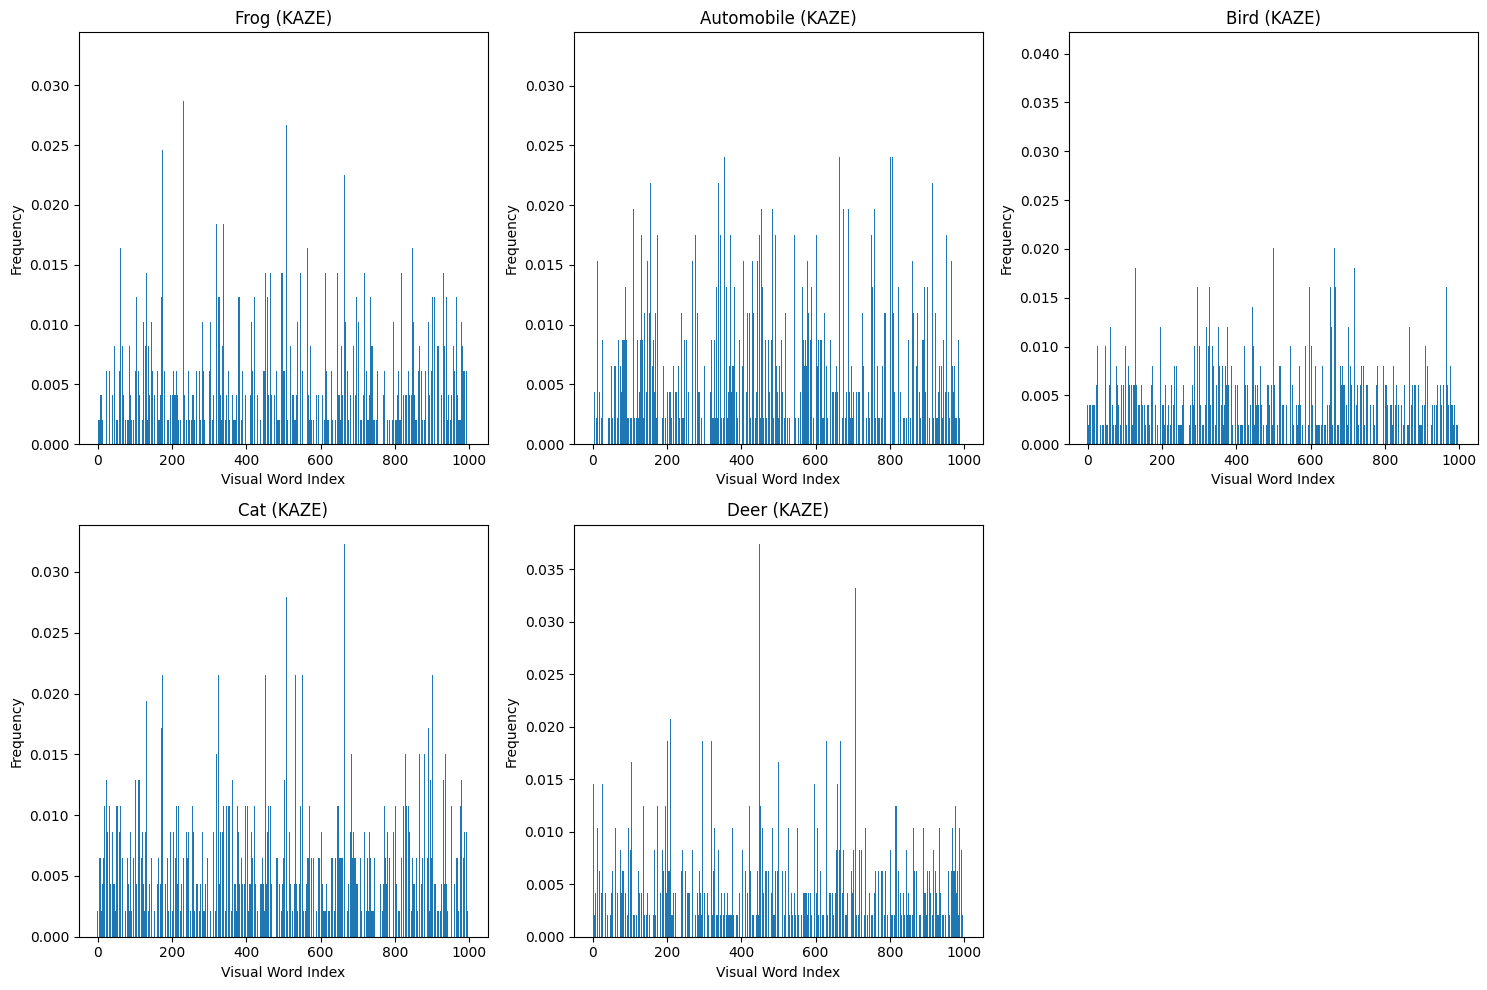

In [23]:
def calculate_mean_histograms(histograms, labels, num_classes):
    mean_histograms = []
    for i in range(num_classes):
        class_histograms = [histograms[j] for j in range(len(labels)) if labels[j] == i]
        if class_histograms:
            mean_histogram = np.mean(class_histograms, axis=0)
        else:
            mean_histogram = np.zeros(histograms[0].shape)
        mean_histograms.append(mean_histogram)
    return mean_histograms

def plot_mean_histograms(mean_histograms, class_names, feature_type):
    num_classes = len(class_names)
    plt.figure(figsize=(15, 10))
    for i in range(num_classes):
        plt.subplot(2, (num_classes + 1) // 2, i + 1)
        plt.bar(range(len(mean_histograms[i])), mean_histograms[i])
        plt.title(f'{class_names[i]} ({feature_type})')
        plt.xlabel('Visual Word Index')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
class_names = ['Frog', 'Automobile', 'Bird', 'Cat', 'Deer']
num_classes = len(class_names)
sift_mean_histograms = calculate_mean_histograms(sift_histograms, valid_labels_sift[2] , num_classes)
kaze_mean_histograms = calculate_mean_histograms(kaze_histograms, valid_labels_kaze[2] , num_classes)
plot_mean_histograms(sift_mean_histograms, class_names, 'SIFT')
plot_mean_histograms(kaze_mean_histograms, class_names, 'KAZE')

<a id="section-6"></a>
### **Section 6: Encoding Test Image Features (0 points)**

In this section, the task is to encode the test image features using the visual vocabulary created from the training set. Similar to the previous encoding step, each test image will be represented as a histogram of visual words, which will then be used for evaluating classification performance.

Use the same two feature extraction techniques you selected earlier. Extract keypoints and descriptors for the test images, then encode these images using the visual vocabulary. This will allow you to compare the encoded features of test images against those of the training set.

**Hint:** Reuse the functions developed earlier for extracting keypoints, descriptors, and encoding images. Ensure that you use the visual vocabulary constructed with the training images for consistency.

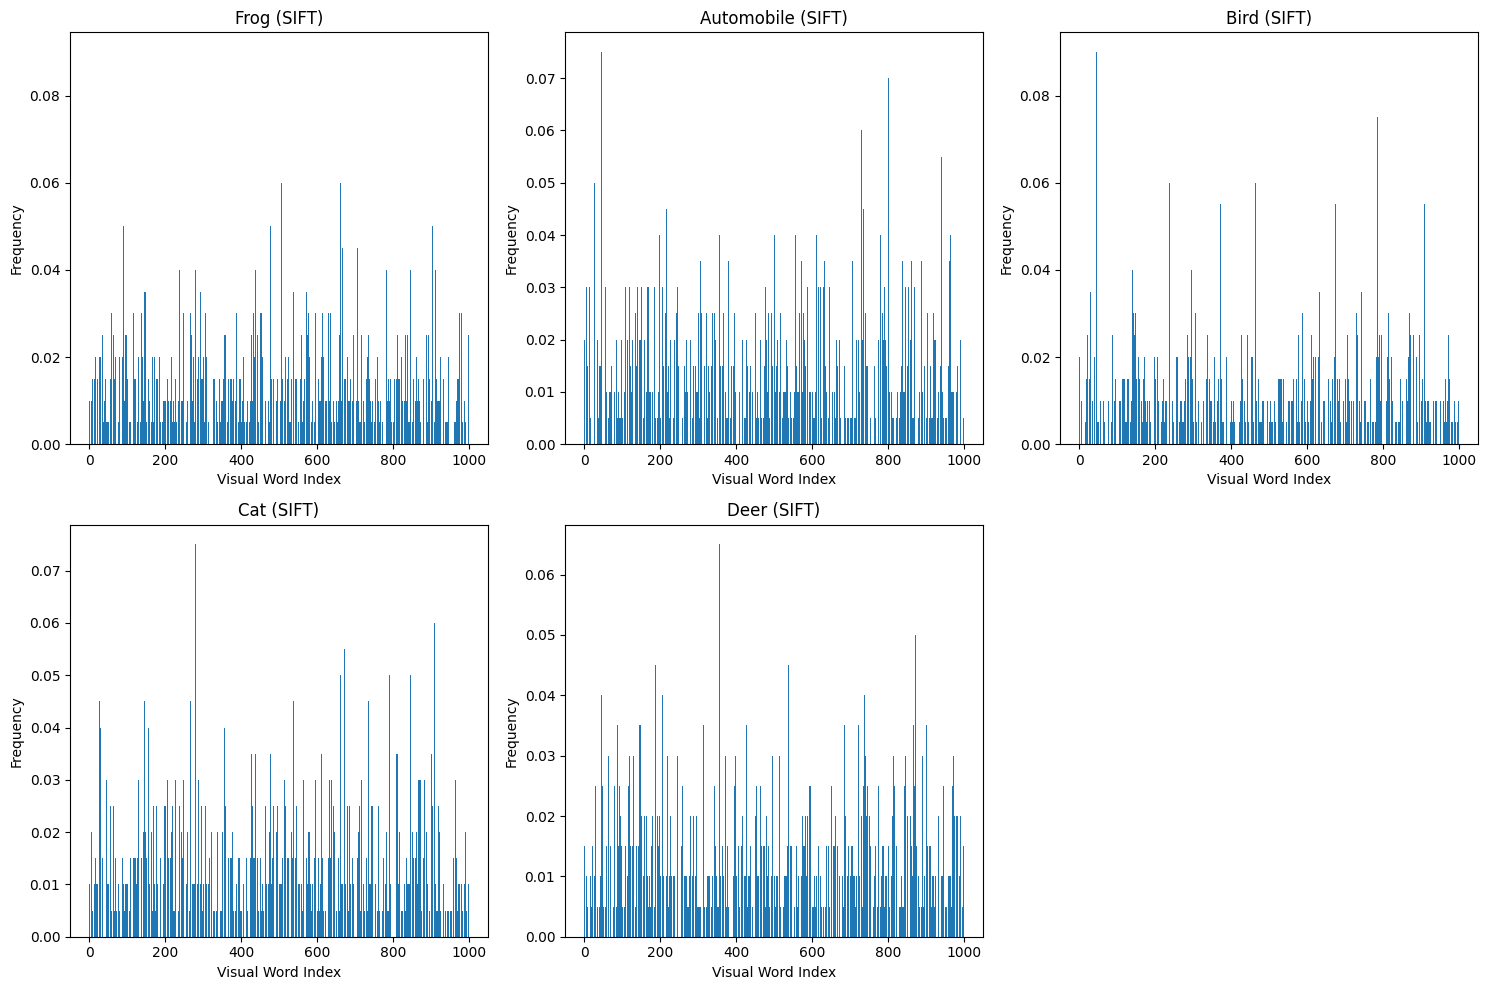

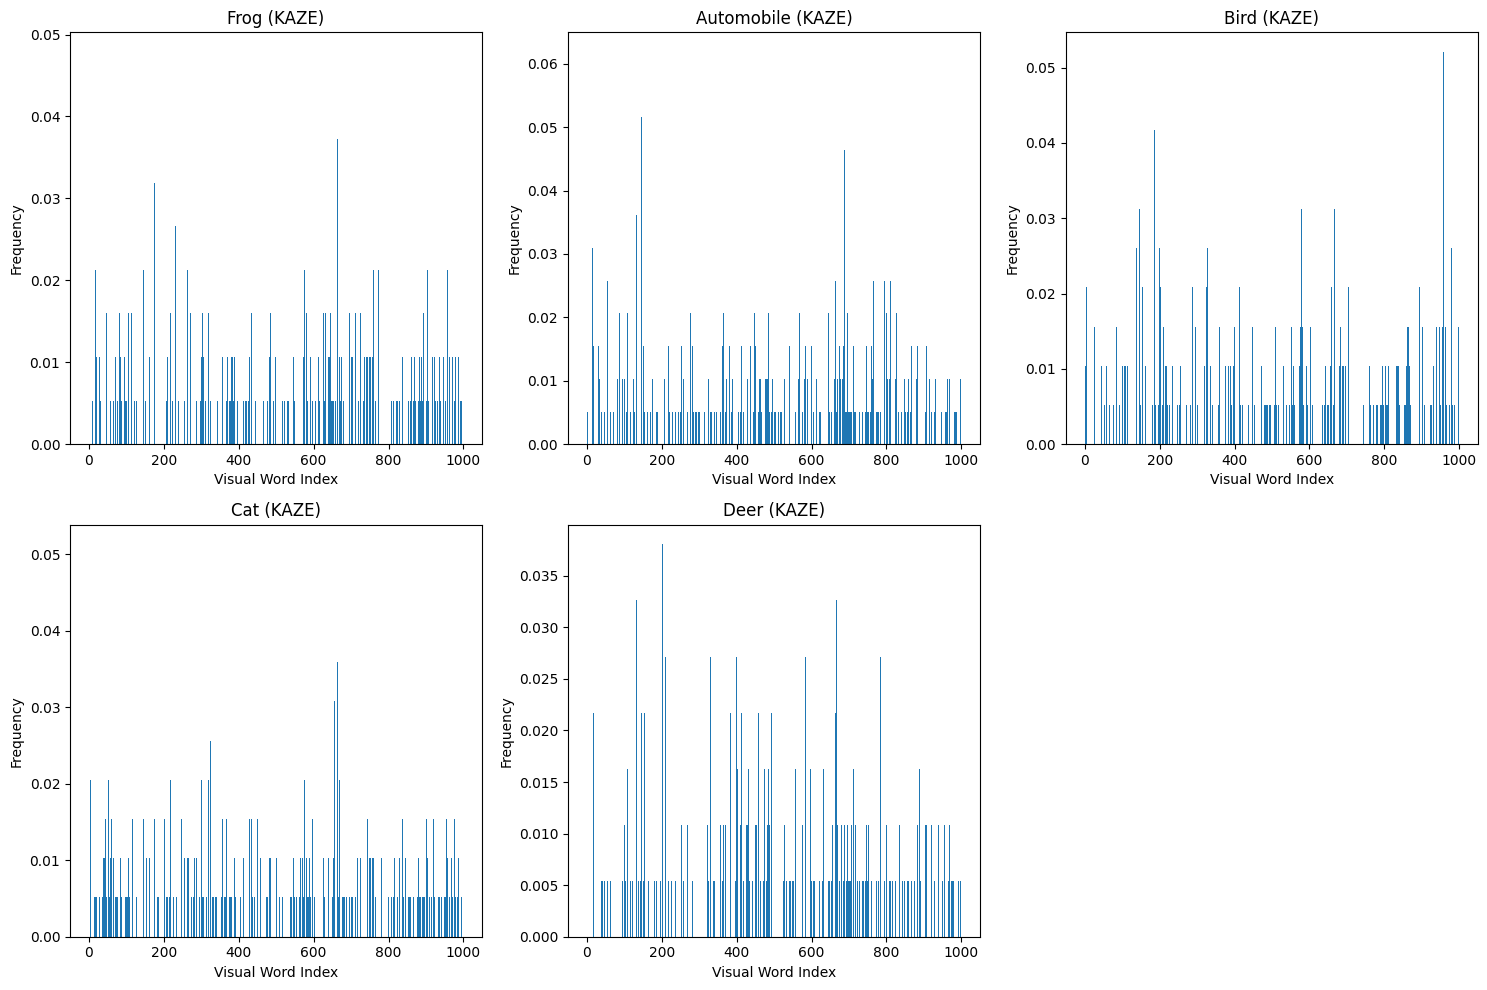

In [24]:
sift_test_descriptors, valid_labels_test_sift = extract_descriptors(test_images.numpy(), test_labels, method='sift')
kaze_test_descriptors, valid_labels_test_kaze = extract_descriptors(test_images.numpy(), test_labels, method='kaze')
sift_test_histograms = encode_features(sift_test_descriptors, kmeans_sift[2], num_clusters)
kaze_test_histograms = encode_features(kaze_test_descriptors, kmeans_kaze[2], num_clusters)
sift_mean_histograms_test = calculate_mean_histograms(sift_test_histograms, valid_labels_test_sift, num_classes)
kaze_mean_histograms_test = calculate_mean_histograms(kaze_test_histograms, valid_labels_test_kaze, num_classes)
plot_mean_histograms(sift_mean_histograms_test, class_names, 'SIFT')
plot_mean_histograms(kaze_mean_histograms_test, class_names, 'KAZE')

<a id="section-7"></a>
### **Section 7: Training the Classifiers (5 points)**

In this section, the task is to create two one-vs-rest (OvR) SVM classifiers using the 50% of the training data that was **not** used for creating the visual dictionary. This ensures that the classifiers are trained on a different subset of data, providing a more robust evaluation of the visual vocabulary's effectiveness.

For each of the two selected feature extraction techniques, create one-vs-rest classifiers for all classes. For now, use default parameter values when training the classifiers; you will experiment with different hyperparameters in later steps.

**Note:** Training an OvR classifier can take around 5 to 7 minutes. Therefore, it's advisable to first test your code with a smaller subset of the training data to verify that your implementation works correctly before running it on the full dataset.

In [25]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import torch


for i in range(0,3):
    
    train_images_classifier = [img.numpy() for img in train_images[num_images_to_use[i]:]]  # Second % of images
    train_labels_classifier = train_labels[num_images_to_use[i]:]

    sift_histograms_classifier = encode_features(sift_descriptors[i], kmeans_sift[i], num_clusters)
    kaze_histograms_classifier = encode_features(kaze_descriptors[i], kmeans_kaze[i], num_clusters)

    valid_sift_ints = [int(tensor.item()) for tensor in valid_labels_sift[i]]
    sift_classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
    sift_classifier.fit(sift_histograms_classifier, valid_sift_ints)

    valid_kaze_ints = [int(tensor.item()) for tensor in valid_labels_kaze[i]]
    kaze_classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
    kaze_classifier.fit(kaze_histograms_classifier, valid_kaze_ints)

    sift_test_predictions = sift_classifier.predict(sift_test_histograms)
    kaze_test_predictions = kaze_classifier.predict(kaze_test_histograms)

    print("SIFT Classifier Report:")
    print(classification_report(valid_labels_test_sift, sift_test_predictions, target_names=class_names))

    print("KAZE Classifier Report:")
    print(classification_report(valid_labels_test_kaze, kaze_test_predictions, target_names=class_names))

SIFT Classifier Report:
              precision    recall  f1-score   support

        Frog       0.22      0.21      0.22       200
  Automobile       0.18      0.14      0.15       200
        Bird       0.21      0.26      0.23       200
         Cat       0.22      0.17      0.19       200
        Deer       0.17      0.23      0.20       200

    accuracy                           0.20      1000
   macro avg       0.20      0.20      0.20      1000
weighted avg       0.20      0.20      0.20      1000

KAZE Classifier Report:
              precision    recall  f1-score   support

        Frog       0.18      0.20      0.19       188
  Automobile       0.24      0.21      0.22       194
        Bird       0.18      0.19      0.19       192
         Cat       0.18      0.16      0.17       195
        Deer       0.21      0.23      0.22       184

    accuracy                           0.20       953
   macro avg       0.20      0.20      0.20       953
weighted avg       0.20      

<a id="section-8"></a>
### **Section 8: Evaluating the Classifiers (12 points)**

In this section, you will evaluate the performance of your one-vs-rest (OvR) SVM classifiers on the test data. The goal is to classify each test image using each binary classifier and rank the images based on the classification scores, resulting in a ranked list of images for each class. Ideally, images belonging to the target class should appear at the top of the respective list. To conduct this evaluation, use the test image histograms generated earlier for the two selected feature extraction techniques. Classify each test image with each classifier, rank them based on their confidence scores, and then compute the Mean Average Precision (mAP) across all classes. The mAP for a single class $c$ is defined as:

$
\text{mAP}_c = \frac{1}{m_c} \sum_{i=1}^{n} \frac{f_c(x_i)}{i}
$

where:
- $n$ is the total number of images ($n = 50 \times 5 = 250$),
- $m_c$ is the number of images of class $c$ ($m_c = 50$),
- $x_i$ is the $i^{th}$ image in the ranked list $X = \{ x_1, x_2, \dots, x_n \}$,
- $f_c$ is a function that returns the number of images of class $c$ in the first $i$ images if $x_i$ is of class $c$, and 0 otherwise.

For instance, if you are retrieving images of class "R" and the sequence of ranked images is $[R, R, T, R, T, T, R, T]$, then $n = 8$, $m_c = 4$, and:

$
AP = \frac{1}{4} \left( \frac{1}{1} + \frac{2}{2} + \frac{0}{3} + \frac{3}{4} + \frac{0}{5} + \frac{0}{6} + \frac{4}{7} + \frac{0}{8} \right).
$

In addition to the quantitative analysis, perform a qualitative analysis by visualizing the top-5 and bottom-5 ranked test images.

In [26]:
from sklearn.metrics import average_precision_score

def compute_rankings_and_ap(test_probabilities, test_labels, class_names):
    ap_scores = []
    ranked_images_per_class = {}
    test_labels=np.array(test_labels)
    binary_labels = []

    for idx, class_name in enumerate(class_names):
        class_probabilities = test_probabilities[:, idx]
        
        ranked_indices = np.argsort(-class_probabilities)
        ranked_images_per_class[class_name] = ranked_indices

        binary_labels = (test_labels == idx)
        ranked_binary_labels = binary_labels[ranked_indices]

        precisions = []
        num_true_positives = 0
        for i, label in enumerate(ranked_binary_labels):
            if label == 1:
                num_true_positives += 1
                precision_at_i = num_true_positives / (i + 1)
                precisions.append(precision_at_i)

        if len(precisions) > 0:
            ap = np.mean(precisions)
        else:
            ap = 0 

        ap_scores.append(ap)

    mean_ap = np.mean(ap_scores)
    return mean_ap, ranked_images_per_class
    
sift_test_probabilities = sift_classifier.predict_proba(sift_test_histograms)
kaze_test_probabilities = kaze_classifier.predict_proba(kaze_test_histograms)

print("Evaluating SIFT Classifier...")
sift_map, sift_ranked_images = compute_rankings_and_ap(sift_test_probabilities, valid_labels_test_sift, class_names)
print(f"SIFT mAP: {sift_map}")
print("Evaluating KAZE Classifier...")
kaze_map, kaze_ranked_images = compute_rankings_and_ap(kaze_test_probabilities, valid_labels_test_kaze, class_names)
print(f"KAZE mAP: {kaze_map}")

Evaluating SIFT Classifier...
SIFT mAP: 0.3068483272615831
Evaluating KAZE Classifier...
KAZE mAP: 0.31014146866288206


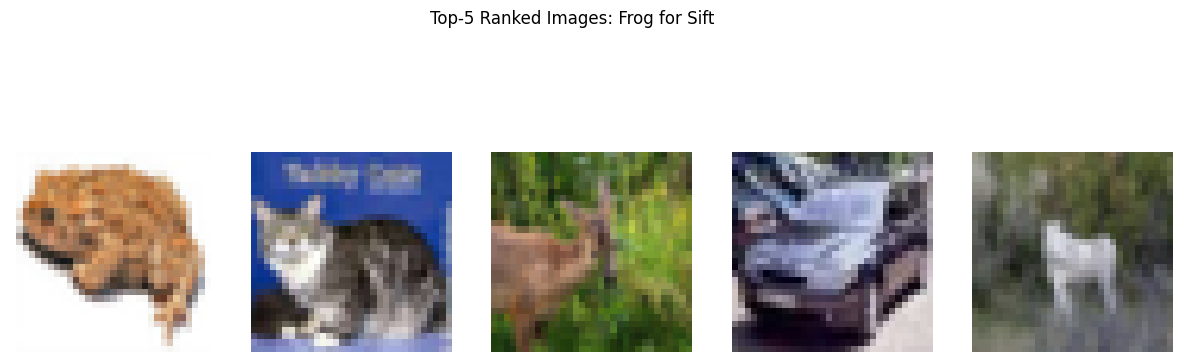

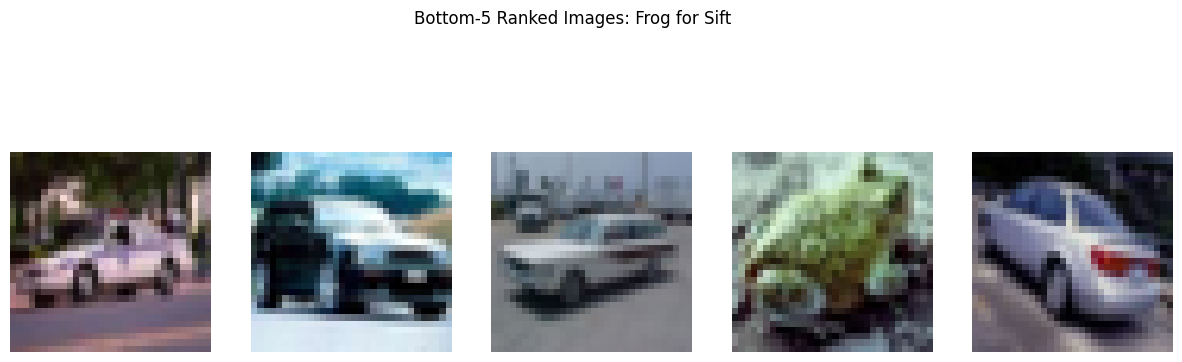

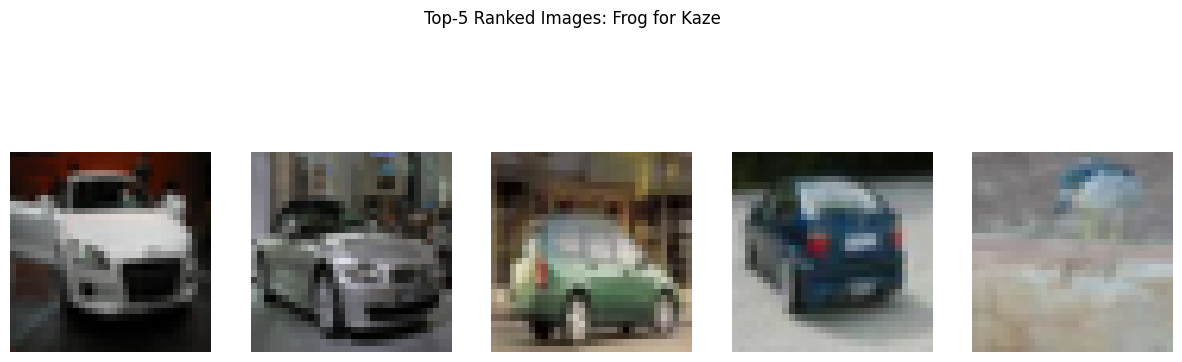

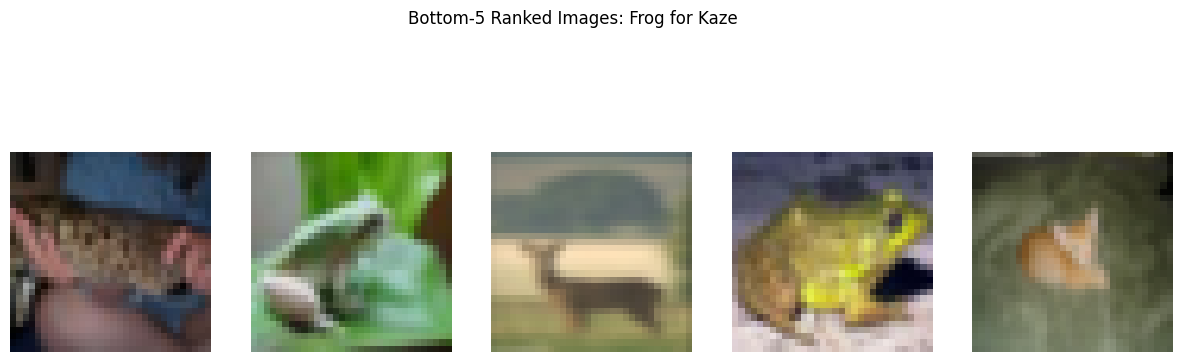

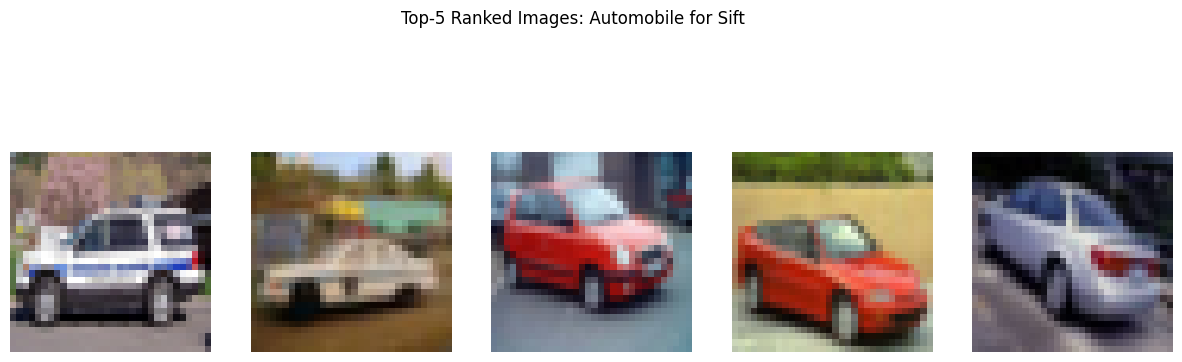

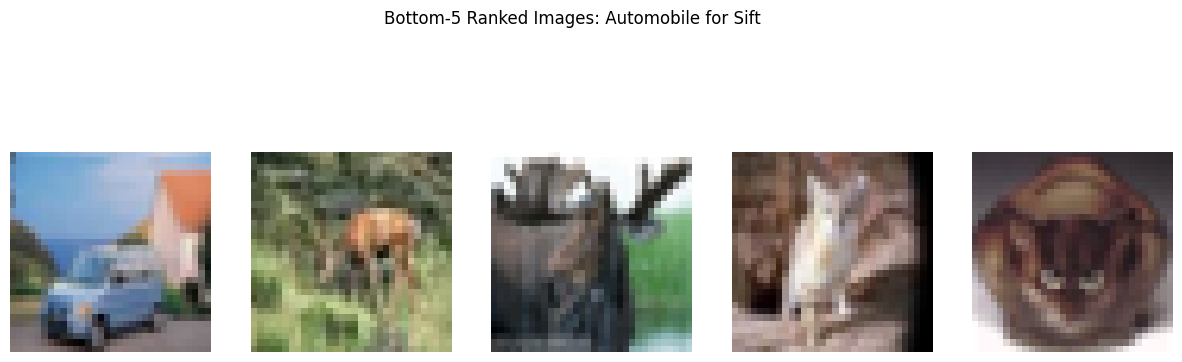

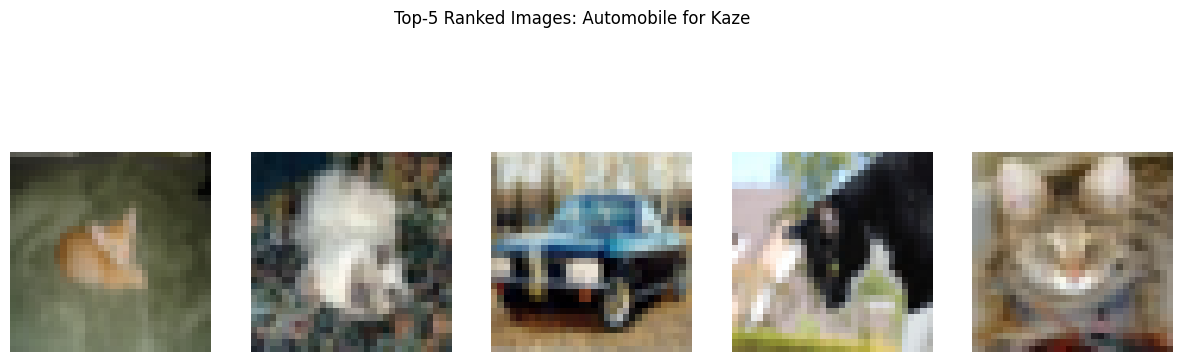

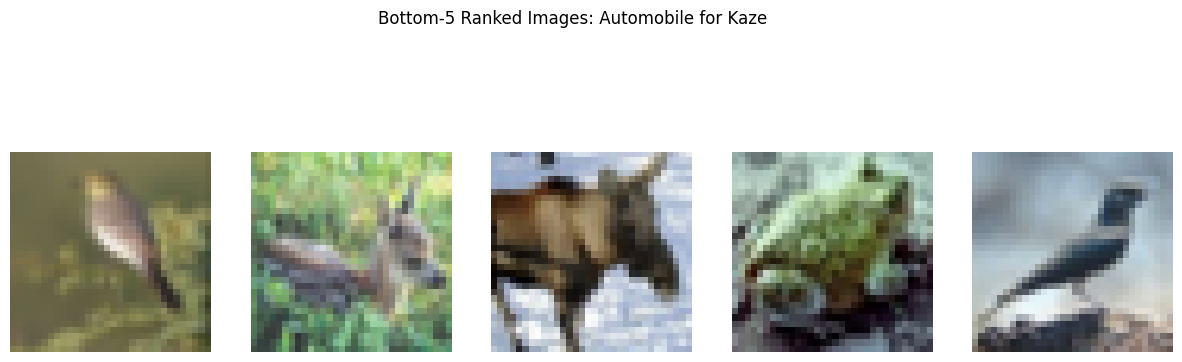

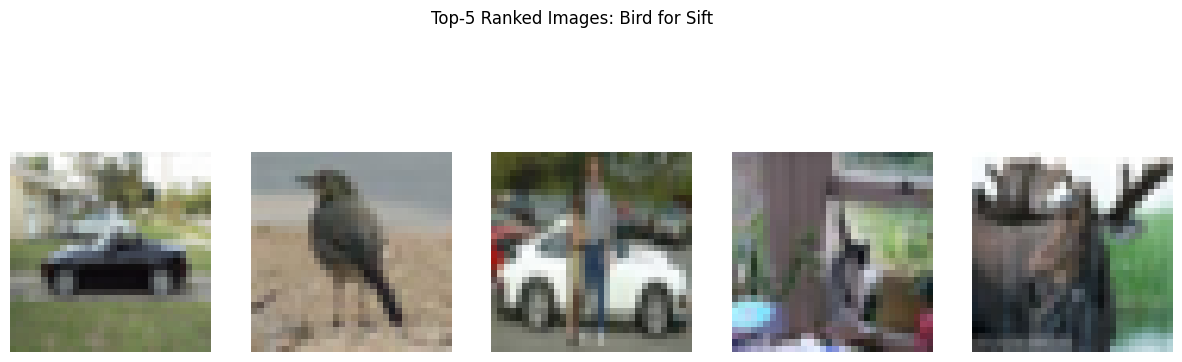

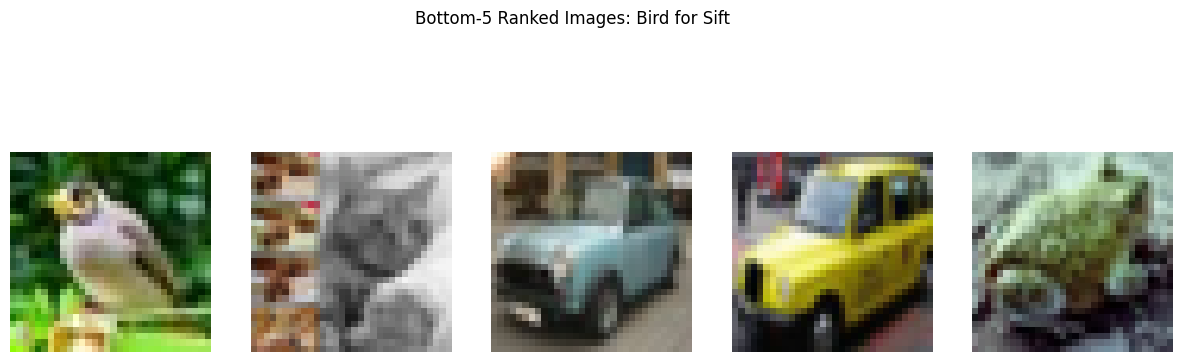

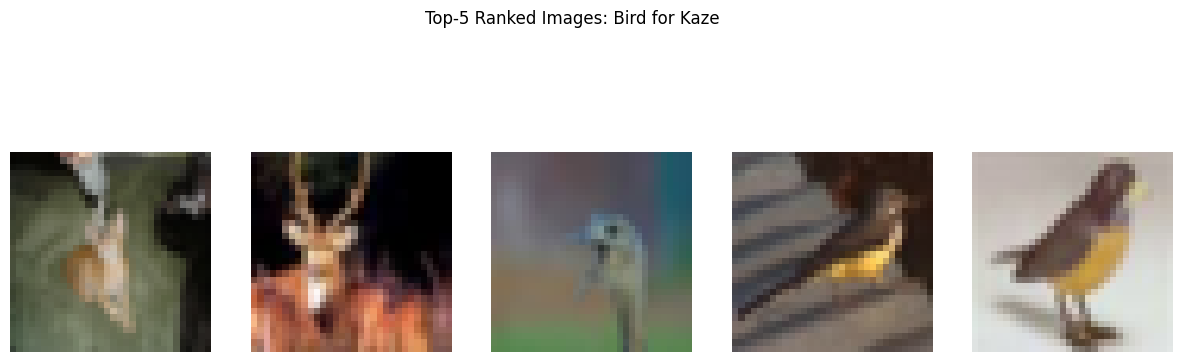

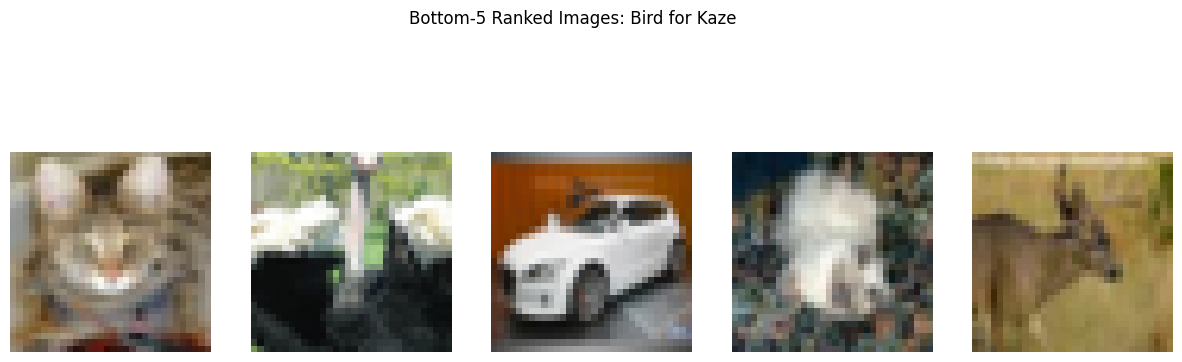

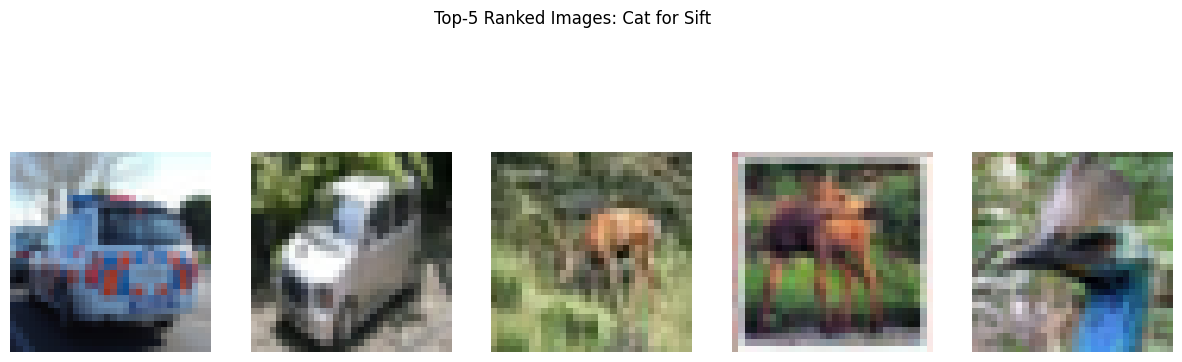

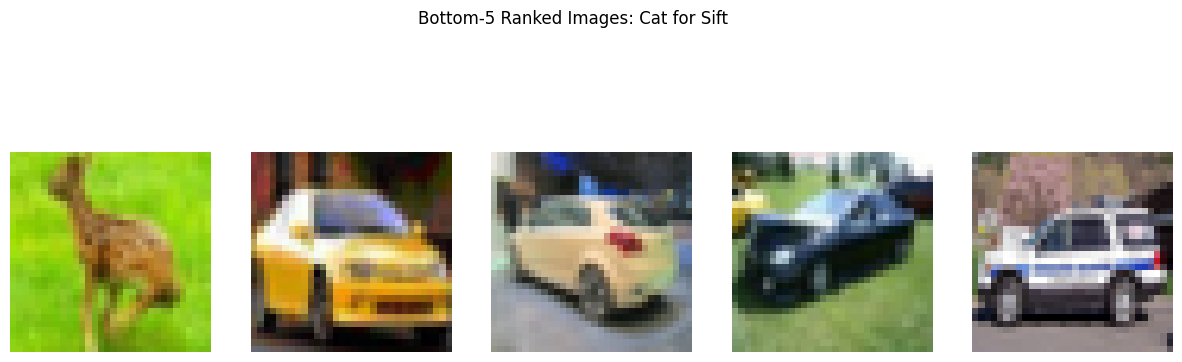

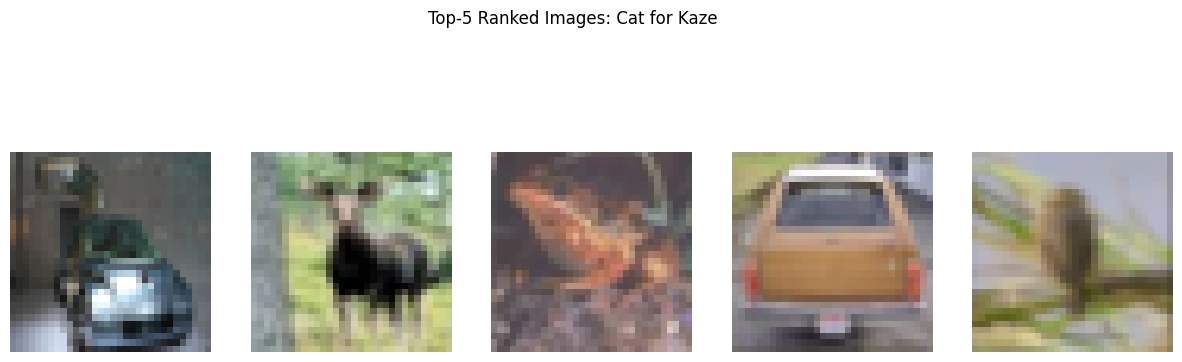

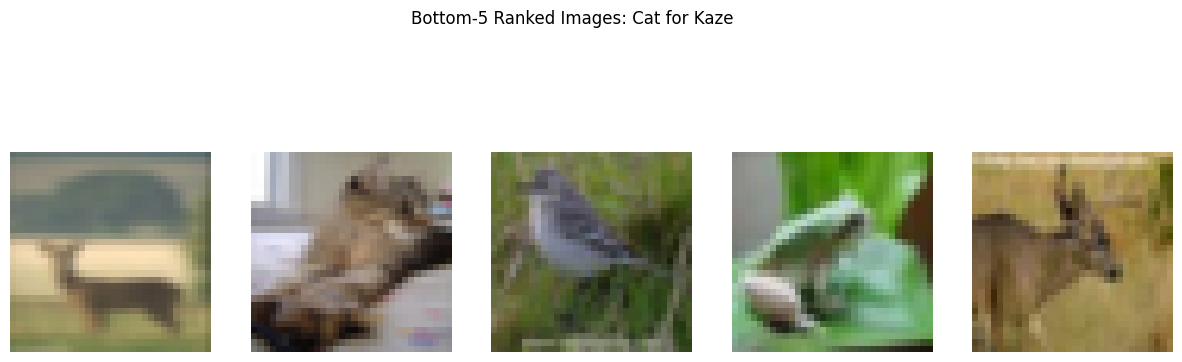

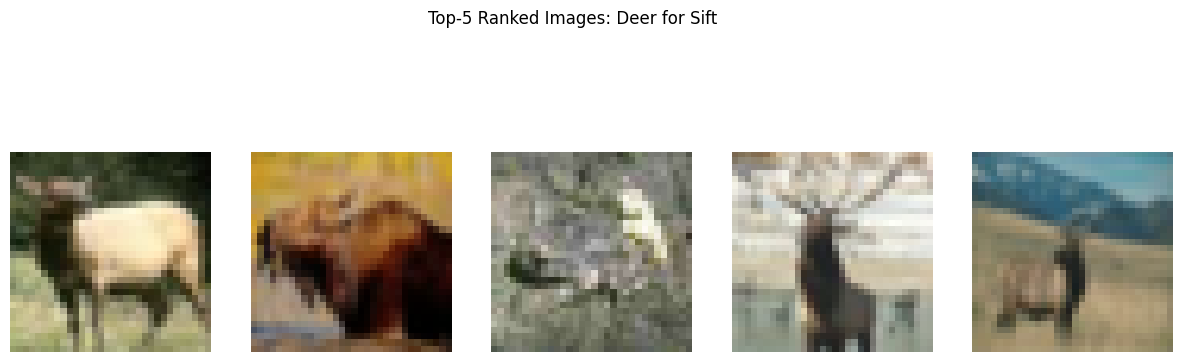

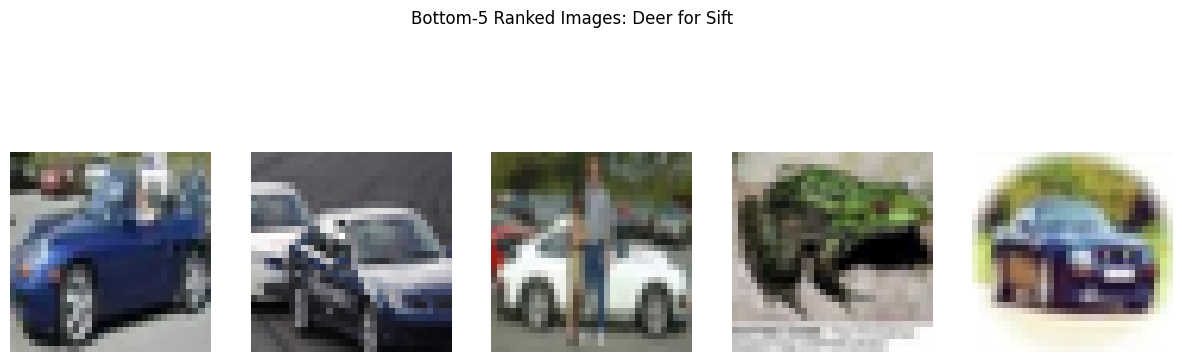

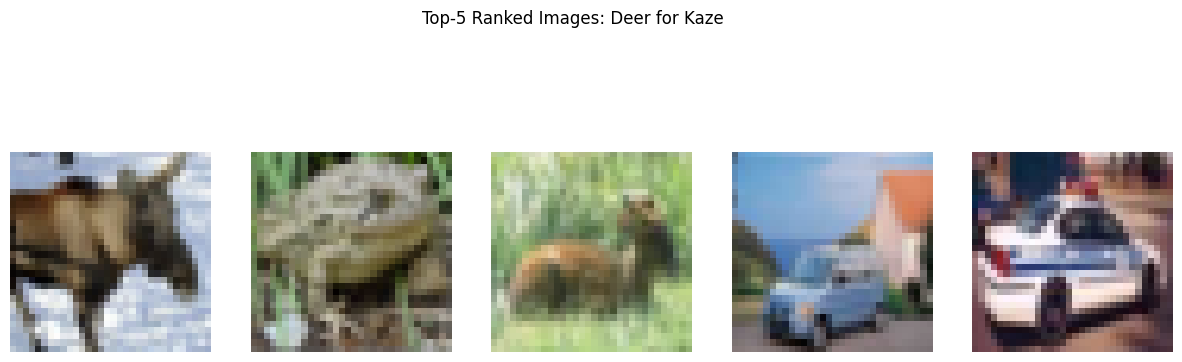

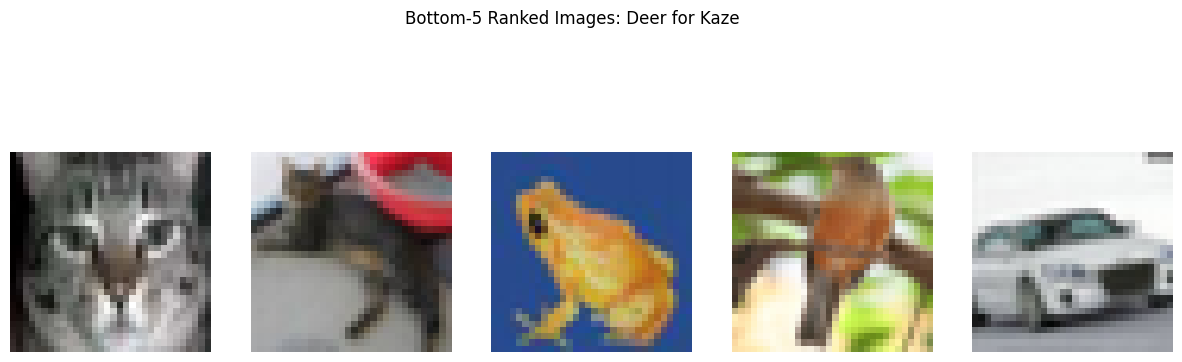

In [12]:
def visualize_top_and_bottom_images(test_images, ranked_indices, class_name, name, num_images=5):
    top_indices = ranked_indices[:num_images]
    bottom_indices = ranked_indices[-num_images:]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(top_indices):
        axes[i].imshow((test_images[idx]+1)/2, cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Top-5 Ranked Images: {class_name} for {name}",fontsize=12)
    plt.show()

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(bottom_indices):
        axes[i].imshow((test_images[idx]+1)/2, cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Bottom-5 Ranked Images: {class_name} for {name}",fontsize=12)
    plt.show()
for c in class_names:
    visualize_top_and_bottom_images(test_images, sift_ranked_images[c], c, "Sift", num_images=5)
    visualize_top_and_bottom_images(test_images, kaze_ranked_images[c], c, "Kaze", num_images=5)

<a id="section-9"></a>
### **Section 9: Hyperparameter Search (16 points)**

In this section, the task is to perform an extensive hyperparameter search to optimize the performance of your classifiers. You will experiment with various parameters, including the number of visual words (e.g., 500, 1000, 1500), different training subset sizes (e.g., 30%, 40%, 50%), SVM parameters (e.g., kernel types like 'linear' or 'rbf', regularization parameter $C$ values such as 0.1, 1, 10, and gamma settings like 'scale' or specific values such as 0.01, 0.001), and settings of the feature extractors (e.g., the number of keypoints or scale levels). Start by testing your code on the smallest subset to ensure it functions correctly before proceeding with a full hyperparameter search. Once validated, conduct the search using larger subsets and systematically iterate through the different parameter combinations, potentially using nested loops or grid search. Be sure to record the performance results for each combination to identify the best settings based on metrics like the Mean Average Precision (mAP).

In [29]:
import pandas as pd
from tqdm import tqdm


default_num_visual_words = 1000
default_subset_size = 0.5
default_kernel = 'linear'
default_reg_param = 1
default_gamma = 'scale'
default_num_keypoints = None
default_octave_layers = None
default_kaze_threshold = None
default_upscale_factor = 1

# Define hyperparameter ranges
num_visual_words_list = [500, 1000, 1500]
training_subset_sizes = [0.3, 0.4, 0.5]
kernel_types = ['linear', 'rbf']
regularization_params = [0.1, 1, 10]
gamma_values = ['scale', 0.1, 0.01]
num_keypoints_list = [10, 50, 100, None]
octave_layers_list = [3, 5, 7, None] 
kaze_threshold_list = [0.001, 0.002, 0.005] 
upscale_factors = [1, 4, 8] 


def evaluate_model(num_visual_words, subset_size, kernel, reg_param, gamma, num_keypoints, kaze_threshold, octave_layers, upscale_factor):
    num_images_to_use_hyper = int(len(train_images) * subset_size)
    selected_images_hyper = [train_images.numpy()[i] for i in range(num_images_to_use_hyper)]
    selected_labels_hyper = train_labels[:num_images_to_use_hyper]

    selected_images_hyper = [cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_LINEAR) for img in selected_images_hyper]

    sift_descriptors_hyper, valid_labels_sift_hyper = extract_descriptors(
        selected_images_hyper, selected_labels_hyper, method='sift', 
        num_keypoints=num_keypoints, num_octave_layers=octave_layers)

    kmeans_sift_hyper = build_visual_vocabulary(sift_descriptors_hyper, num_visual_words)

    kaze_descriptors_hyper, valid_labels_kaze_hyper = extract_descriptors(
        selected_images_hyper, selected_labels_hyper, method='kaze', threshold=kaze_threshold)

    kmeans_kaze_hyper = build_visual_vocabulary(kaze_descriptors_hyper, num_visual_words)

    num_subset = int(num_images_to_use_hyper + num_images_to_use_hyper * subset_size)
    train_images_classifier_hyper = [train_images.numpy()[i] for i in range(num_images_to_use_hyper, num_subset)]
    train_labels_classifier_hyper = train_labels[num_images_to_use_hyper:num_subset]

    train_images_classifier_hyper = [cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_LINEAR) for img in train_images_classifier_hyper]

    sift_descriptors_classifier_hyper, valid_sift_hyper = extract_descriptors(
        train_images_classifier_hyper, train_labels_classifier_hyper, method='sift', 
        num_keypoints=num_keypoints, num_octave_layers=octave_layers)

    kaze_descriptors_classifier_hyper, valid_kaze_hyper = extract_descriptors(
        train_images_classifier_hyper, train_labels_classifier_hyper, method='kaze', threshold=kaze_threshold)

    sift_histograms_classifier_hyper = encode_features(sift_descriptors_classifier_hyper, kmeans_sift_hyper, num_visual_words)
    kaze_histograms_classifier_hyper = encode_features(kaze_descriptors_classifier_hyper, kmeans_kaze_hyper, num_visual_words)

    test_images_hyper = [img.numpy() for img in test_images]
    test_labels_hyper = test_labels

    test_images_hyper = [cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_LINEAR) for img in test_images_hyper]


    sift_test_descriptors_hyper, valid_labels_test_sift_hyper = extract_descriptors(
        test_images_hyper, test_labels_hyper, method='sift', num_keypoints=num_keypoints, 
        num_octave_layers=octave_layers)

    kaze_test_descriptors_hyper, valid_labels_test_kaze_hyper = extract_descriptors(
        test_images_hyper, test_labels_hyper, method='kaze', threshold=kaze_threshold)

    sift_test_histograms_hyper = encode_features(sift_test_descriptors_hyper, kmeans_sift_hyper, num_visual_words)
    kaze_test_histograms_hyper = encode_features(kaze_test_descriptors_hyper, kmeans_kaze_hyper, num_visual_words)

    valid_sift_hyper_ints = [int(tensor.item()) for tensor in valid_sift_hyper]
    svm_classifier_hyper_sift = OneVsRestClassifier(SVC(kernel=kernel, C=reg_param, gamma=gamma, probability=True, random_state=42))
    svm_classifier_hyper_sift.fit(sift_histograms_classifier_hyper, valid_sift_hyper_ints)

    valid_kaze_hyper_ints = [int(tensor.item()) for tensor in valid_kaze_hyper]
    svm_classifier_hyper_kaze = OneVsRestClassifier(SVC(kernel=kernel, C=reg_param, gamma=gamma, probability=True, random_state=42))
    svm_classifier_hyper_kaze.fit(kaze_histograms_classifier_hyper, valid_kaze_hyper_ints)

    test_probabilities_sift_hyper = svm_classifier_hyper_sift.predict_proba(sift_test_histograms_hyper)
    test_probabilities_kaze_hyper = svm_classifier_hyper_kaze.predict_proba(kaze_test_histograms_hyper)

    mAP_sift, _ = compute_rankings_and_ap(test_probabilities_sift_hyper, valid_labels_test_sift_hyper, class_names)
    mAP_kaze, _ = compute_rankings_and_ap(test_probabilities_kaze_hyper, valid_labels_test_kaze_hyper, class_names)

    # Record the result
    return {
        'num_visual_words': num_visual_words,
        'subset_size': subset_size,
        'kernel': kernel,
        'reg_param': reg_param,
        'gamma': gamma,
        'num_keypoints': num_keypoints,
        'kaze_threshold': kaze_threshold,
        'octave_layers': octave_layers,
        'upscale_factor': upscale_factor,
        'mAP Sift': mAP_sift,  
        'mAP Kaze': mAP_kaze   
    }



results = []
for num_visual_words in tqdm(num_visual_words_list, desc="Varying num_visual_words"):
    result = evaluate_model(num_visual_words, default_subset_size, default_kernel, default_reg_param, default_gamma, default_num_keypoints, default_kaze_threshold, default_octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))

results = []
for subset_size in tqdm(training_subset_sizes, desc="Varying subset_size"):
    result = evaluate_model(default_num_visual_words, subset_size, default_kernel, default_reg_param, default_gamma, default_num_keypoints, default_kaze_threshold, default_octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))

results = []
for kernel in tqdm(kernel_types, desc="Varying kernel"):
    result = evaluate_model(default_num_visual_words, default_subset_size, kernel, default_reg_param, default_gamma, default_num_keypoints, default_kaze_threshold, default_octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))

results = []
for reg_param in tqdm(regularization_params, desc="Varying regularization_params"):
    result = evaluate_model(default_num_visual_words, default_subset_size, default_kernel, reg_param, default_gamma, default_num_keypoints, default_kaze_threshold, default_octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))

results = []
for gamma in tqdm(gamma_values, desc="Varying gamma_values"):
    result = evaluate_model(default_num_visual_words, default_subset_size, default_kernel, default_reg_param, gamma, default_num_keypoints, default_kaze_threshold, default_octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))

results = []
for num_keypoints in tqdm(num_keypoints_list, desc="Varying num_keypoints"):
    result = evaluate_model(default_num_visual_words, default_subset_size, default_kernel, default_reg_param, default_gamma, num_keypoints, default_kaze_threshold, default_octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))

results = []
for octave_layers in tqdm(octave_layers_list, desc="Varying octave_layers"):
    result = evaluate_model(default_num_visual_words, default_subset_size, default_kernel, default_reg_param, default_gamma, default_num_keypoints, default_kaze_threshold, octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))

results = []
for kaze_threshold in tqdm(kaze_threshold_list, desc="Varying kaze_threshold"):
    result = evaluate_model(default_num_visual_words, default_subset_size, default_kernel, default_reg_param, default_gamma, default_num_keypoints, kaze_threshold, default_octave_layers, default_upscale_factor)
    results.append(result)
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='mAP Sift', ascending=False))
print(results_df.sort_values(by='mAP Kaze', ascending=False))


results = []


for upscale_factor in tqdm(upscale_factors, desc="Varying upscale_factor"):
    result = evaluate_model(
        num_visual_words=default_num_visual_words,
        subset_size=default_subset_size,
        kernel=default_kernel,
        reg_param=default_reg_param,
        gamma=default_gamma,
        num_keypoints=default_num_keypoints,
        kaze_threshold=default_kaze_threshold,
        octave_layers=default_octave_layers,
        upscale_factor=upscale_factor
    )
    results.append(result)

results_df = pd.DataFrame(results)
print("Results sorted by mAP Sift:")
print(results_df.sort_values(by='mAP Sift', ascending=False))
print("\nResults sorted by mAP Kaze:")
print(results_df.sort_values(by='mAP Kaze', ascending=False))




Varying num_visual_words: 100%|██████████| 3/3 [04:09<00:00, 83.02s/it]


   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0               500          0.5  linear          1  scale          None   
1              1000          0.5  linear          1  scale          None   
2              1500          0.5  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           None          None               1  0.287323  0.280079  
1           None          None               1  0.287166  0.283483  
2           None          None               1  0.280332  0.280023  
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
1              1000          0.5  linear          1  scale          None   
0               500          0.5  linear          1  scale          None   
2              1500          0.5  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
1           None          None               

Varying subset_size: 100%|██████████| 3/3 [02:40<00:00, 53.55s/it]


   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
2              1000          0.5  linear          1  scale          None   
0              1000          0.3  linear          1  scale          None   
1              1000          0.4  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
2           None          None               1  0.287166  0.283483  
0           None          None               1  0.263850  0.270391  
1           None          None               1  0.256327  0.243683  
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
2              1000          0.5  linear          1  scale          None   
0              1000          0.3  linear          1  scale          None   
1              1000          0.4  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
2           None          None               

Varying kernel: 100%|██████████| 2/2 [03:19<00:00, 99.64s/it] 


   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
1              1000          0.5     rbf          1  scale          None   
0              1000          0.5  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
1           None          None               1  0.343207  0.313739  
0           None          None               1  0.287166  0.283483  
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
1              1000          0.5     rbf          1  scale          None   
0              1000          0.5  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
1           None          None               1  0.343207  0.313739  
0           None          None               1  0.287166  0.283483  


Varying regularization_params: 100%|██████████| 3/3 [03:56<00:00, 78.74s/it]


   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0              1000          0.5  linear        0.1  scale          None   
1              1000          0.5  linear        1.0  scale          None   
2              1000          0.5  linear       10.0  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           None          None               1  0.324890  0.302868  
1           None          None               1  0.287166  0.283483  
2           None          None               1  0.284132  0.274618  
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0              1000          0.5  linear        0.1  scale          None   
1              1000          0.5  linear        1.0  scale          None   
2              1000          0.5  linear       10.0  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           None          None               

Varying gamma_values: 100%|██████████| 3/3 [03:54<00:00, 78.19s/it]


   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0              1000          0.5  linear          1  scale          None   
1              1000          0.5  linear          1    0.1          None   
2              1000          0.5  linear          1   0.01          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           None          None               1  0.287166  0.283483  
1           None          None               1  0.287166  0.283483  
2           None          None               1  0.287166  0.283483  
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0              1000          0.5  linear          1  scale          None   
1              1000          0.5  linear          1    0.1          None   
2              1000          0.5  linear          1   0.01          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           None          None               

Varying num_keypoints: 100%|██████████| 4/4 [04:56<00:00, 74.11s/it]


   num_visual_words  subset_size  kernel  reg_param  gamma  num_keypoints  \
0              1000          0.5  linear          1  scale           10.0   
1              1000          0.5  linear          1  scale           50.0   
2              1000          0.5  linear          1  scale          100.0   
3              1000          0.5  linear          1  scale            NaN   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           None          None               1  0.296341  0.283483  
1           None          None               1  0.287166  0.283483  
2           None          None               1  0.287166  0.283483  
3           None          None               1  0.287166  0.283483  
   num_visual_words  subset_size  kernel  reg_param  gamma  num_keypoints  \
0              1000          0.5  linear          1  scale           10.0   
1              1000          0.5  linear          1  scale           50.0   
2              1000          0.5  line

Varying octave_layers: 100%|██████████| 4/4 [04:40<00:00, 70.01s/it]


   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
2              1000          0.5  linear          1  scale          None   
1              1000          0.5  linear          1  scale          None   
0              1000          0.5  linear          1  scale          None   
3              1000          0.5  linear          1  scale          None   

  kaze_threshold  octave_layers  upscale_factor  mAP Sift  mAP Kaze  
2           None            7.0               1  0.313696  0.283483  
1           None            5.0               1  0.301577  0.283483  
0           None            3.0               1  0.287166  0.283483  
3           None            NaN               1  0.287166  0.283483  
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0              1000          0.5  linear          1  scale          None   
1              1000          0.5  linear          1  scale          None   
2              1000          0.5  linear 

Varying kaze_threshold: 100%|██████████| 3/3 [03:33<00:00, 71.07s/it]


   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0              1000          0.5  linear          1  scale          None   
1              1000          0.5  linear          1  scale          None   
2              1000          0.5  linear          1  scale          None   

   kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           0.001          None               1  0.287166  0.283483  
1           0.002          None               1  0.287166  0.264780  
2           0.005          None               1  0.287166  0.214202  
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
0              1000          0.5  linear          1  scale          None   
1              1000          0.5  linear          1  scale          None   
2              1000          0.5  linear          1  scale          None   

   kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
0           0.001          None         

Varying upscale_factor: 100%|██████████| 3/3 [13:58<00:00, 279.60s/it]

Results sorted by mAP Sift:
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
1              1000          0.5  linear          1  scale          None   
2              1000          0.5  linear          1  scale          None   
0              1000          0.5  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift  mAP Kaze  
1           None          None               4  0.331641  0.354515  
2           None          None               8  0.322619  0.353950  
0           None          None               1  0.287166  0.283483  

Results sorted by mAP Kaze:
   num_visual_words  subset_size  kernel  reg_param  gamma num_keypoints  \
1              1000          0.5  linear          1  scale          None   
2              1000          0.5  linear          1  scale          None   
0              1000          0.5  linear          1  scale          None   

  kaze_threshold octave_layers  upscale_factor  mAP Sift 

In [31]:
result = evaluate_model(1000, 0.5, 'rbf', 0.1, 'scale', 100, 0.001, 7, 4)
print(result)

{'num_visual_words': 1000, 'subset_size': 0.5, 'kernel': 'rbf', 'reg_param': 0.1, 'gamma': 'scale', 'num_keypoints': 100, 'kaze_threshold': 0.001, 'octave_layers': 7, 'upscale_factor': 4, 'mAP Sift': 0.4295052610975093, 'mAP Kaze': 0.4290886905906337}


<a id="section-10"></a>
### **Section 10: Using CLIP for Image Classification (5 points)**

**<span style="color:red">⚠️ NOTE: This section should NOT be included in the report. It is only meant to be completed in the code cells. The purpose of this task is to introduce you to a more state-of-the-art model (CLIP) compared to Bag of Visual Words (BoVW). Vision Transformers (ViT) will be covered in more detail in the Deep Learning 1 course next period!</span>**

In this section, you will use a pre-trained CLIP model for image classification. CLIP (Contrastive Language-Image Pretraining) is a vision-language transformer model trained on a large dataset of images and text. It consists of two main components: a Vision Transformer (ViT) and a text Transformer. The ViT encodes images by dividing them into patches (tokens), flattening each patch into a vector, and passing them through a sequence of Transformer layers to produce an encoded representation of the image.

For this task, you will use the visual transformer component of CLIP to extract encoded representations of the input images. While this is not the typical way to use CLIP (which involves encoding both images and text for similarity comparison), it provides an interesting application of this state-of-the-art model for image classification.

**To Install CLIP:**
```python
pip install git+https://github.com/openai/CLIP.git
```

**Additional Reading (if you're interested):**
- [OpenAI CLIP Overview](https://openai.com/clip)
- [Vision Transformer (ViT) Paper](https://arxiv.org/abs/2010.11929)
- [Tutorial on Vision Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [UvA's Deep Learning Introduction to ViTs](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)

First, create DataLoaders for both the training and test datasets by filtering the CIFAR-10 dataset to include only the selected classes: frog, automobile, bird, cat, and deer. Use a batch size of 16 for both DataLoaders, and resize the images to 224x224 to match the input size requirements for CLIP. Remember to normalize the images using the appropriate mean and standard deviation. Use a training set size of 1000 images per class and a test set size of 200 images per class.

In [2]:
# YOUR CODE HERE
!pip install git+https://github.com/openai/CLIP.git

# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Number of classes
num_classes = 5

# Compute images per class for training and testing: 1000 train per class and 200 test per class
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=16, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=16, shuffle=False)

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Platon\AppData\Local\Temp\pip-req-build-l5ewd3jj'


  Cloning https://github.com/openai/CLIP.git to c:\users\platon\appdata\local\temp\pip-req-build-l5ewd3jj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Files already downloaded and verified
Files already downloaded and verified


Next, we load a pre-trained CLIP model, which is a vision-language transformer designed to predict the text that describes an image and vice versa. The model consists of two components: a Vision Transformer (ViT) for encoding images and a text Transformer for encoding text. 

In [3]:
import clip

# Setup the model and the preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

To extract the visual tokens using the CLIP model, start by initializing two empty lists: one for storing the image features and another for the labels. Use `tqdm` to create a progress bar that tracks the extraction process over the DataLoader. Iterate through the DataLoader, extracting images and labels. Disable gradient computation, and then encode the images with `model.encode_image(images)`. Append the encoded features and labels to their respective lists. Remember, the output from the model will have the shape `(batch_size, 512)` due to batched processing, if your are using a single you should reshape the output to `(512,)` to remove the batch dimension.

In this example, we will use the class token as the visual representation of the image. The class token is a 512-dimensional vector that represents the image. We will use this vector to train a classifier to classify the images.

**Note:** The CLIP model is quite large and may take some time to extract features from the images. You can use the `tqdm` library to create a progress bar that shows the extraction progress. It is recommended to test the code with a smaller subset of images to ensure it functions correctly before running it on the full dataset. With the default batch size of 16 and a training set size of 1000 images, the extraction process may take a 10-20 minutes.

In [8]:
from tqdm import tqdm

# intialise empty lists to store image features and image labels
image_features_list = []
target_labels_list = []

# Evaluation Mode
model.eval()

with torch.no_grad():
    for images, labels in tqdm(train_data_loader, desc="Starting Feature Extraction"):
        # move images to device
        images = images.to(device)

        # Encode images
        features =  model.encode_image(images)

        # Reshape the output if using a single image
        if (features.shape[0] == 1):
            # Reshape from (1, 512) to (512,)
            features = features.squeeze(0)

        # Append features and labels to the corresponding lists
        image_features_list.append(features)
        target_labels_list.append(labels)

print("Feature Extraction Complete")
print(f"Image Features Shape: {image_features_list}")
print(f"Image Labels Shape: {target_labels_list}")

Starting Feature Extraction:   0%|          | 0/313 [00:00<?, ?it/s]d:\Emma\Overig\Python\envs\cv1_group4\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Starting Feature Extraction: 100%|██████████| 313/313 [01:49<00:00,  2.86it/s]


Feature Extraction Complete
Image Features Shape: [tensor([[ 0.0406,  0.1033, -0.2084,  ...,  0.8306, -0.1588, -0.2764],
        [-0.0352, -0.1542, -0.0189,  ...,  0.4424,  0.0630,  0.2125],
        [ 0.2698,  0.3438,  0.0660,  ...,  0.5952, -0.0721,  0.3875],
        ...,
        [ 0.0988,  0.2256, -0.0585,  ...,  0.3955, -0.1812,  0.0148],
        [-0.0261, -0.1573, -0.2610,  ...,  0.6304, -0.0576, -0.0944],
        [ 0.2257,  0.2935, -0.1494,  ...,  0.6919,  0.0195,  0.2881]],
       device='cuda:0', dtype=torch.float16), tensor([[ 0.0107,  0.0413, -0.3804,  ...,  0.6699,  0.4272,  0.1087],
        [ 0.2690, -0.0008, -0.4045,  ...,  0.5996, -0.1721,  0.1921],
        [ 0.4067,  0.0914, -0.2566,  ...,  0.3545,  0.1866,  0.3105],
        ...,
        [ 0.4368,  0.4531,  0.0293,  ...,  0.6187, -0.2203,  0.4709],
        [ 0.4973,  0.2927,  0.0534,  ...,  0.7188,  0.1052, -0.2969],
        [ 0.5850,  0.0943, -0.2107,  ...,  0.3064,  0.0206, -0.3022]],
       device='cuda:0', dtype=torch

In [9]:
# Stack the (batched) visual tokens extracted from the images. The resulting shape will be (number_of_images, 512).
stacked_image_features = torch.cat(image_features_list)
stacked_target_labels = torch.cat(target_labels_list)

To train a classifier using the visual tokens, start by initializing an SVM classifier using `SVC()` from `scikit-learn`. You can play around with different hyperparameters such as kernel type, regularization parameter, and gamma to find the best configuration. Finally, use the `fit` method to train the classifier on the visual image features and labels.

In [13]:
from sklearn.svm import SVC
stacked_image_features_cpu = stacked_image_features.cpu().numpy()

stacked_target_labels_cpu = stacked_target_labels.cpu().numpy()
# YOUR CODE HERE
svm_classifier_vit = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
svm_classifier_vit.fit(stacked_image_features_cpu, stacked_target_labels_cpu)

SVC(kernel='linear', random_state=42)

To evaluate the classifier, start by extracting the visual tokens from the test images using the same method applied to the training set. Loop through the test DataLoader, encode each batch of images using the model (e.g., `model.encode_image(images)`), and store the results in separate lists for the features and labels. After extracting all the features, stack them into a single tensor for both the features and labels. This process will prepare the test data for use in evaluating the classifier's performance.

In [16]:
# YOUR CODE HERE
# intialise empty lists to store image features and image labels
image_features_list_test = []
target_labels_list_test = []

# Evaluation Mode
model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_data_loader, desc="Starting Feature Extraction"):
        # move images to device
        images = images.to(device)

        # Encode images
        features =  model.encode_image(images)

        # Reshape the output if using a single image
        if (features.shape[0] == 1):
            # Reshape from (1, 512) to (512,)
            features = features.squeeze(0)

        # Append features and labels to the corresponding lists
        image_features_list_test.append(features)
        target_labels_list_test.append(labels)

print("Feature Extraction Complete")
print(f"Image Features Shape: {image_features_list_test}")
print(f"Image Labels Shape: {target_labels_list_test}")

stacked_image_features_test = torch.cat(image_features_list_test).cpu().numpy()
stacked_target_labels_test = torch.cat(target_labels_list_test).cpu().numpy()

Starting Feature Extraction: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s]


Feature Extraction Complete
Image Features Shape: [tensor([[ 0.2554,  0.2275, -0.4990,  ...,  0.4712, -0.0778,  0.0397],
        [ 0.2827, -0.1243, -0.0891,  ...,  0.4678, -0.1837,  0.0793],
        [ 0.2168, -0.0131, -0.1890,  ...,  0.8345,  0.1377,  0.1180],
        ...,
        [-0.1301,  0.0659,  0.0016,  ...,  0.4038, -0.3933, -0.0753],
        [ 0.4866, -0.1075, -0.2578,  ...,  0.9507, -0.0506, -0.0353],
        [ 0.0709,  0.1746, -0.2164,  ...,  0.5435,  0.2571,  0.2634]],
       device='cuda:0', dtype=torch.float16), tensor([[ 0.1698,  0.2115, -0.1334,  ...,  0.9375, -0.0480,  0.4531],
        [ 0.3960,  0.3867, -0.4758,  ...,  0.5825,  0.2036,  0.0733],
        [ 0.4973,  0.2214, -0.3647,  ...,  0.6958,  0.1342,  0.1775],
        ...,
        [-0.0233,  0.3113, -0.0040,  ...,  0.3977, -0.0677, -0.2072],
        [ 0.4612,  0.0445, -0.2651,  ...,  0.5557, -0.2494,  0.0440],
        [ 0.5425,  0.3342, -0.1390,  ...,  0.6211,  0.0961, -0.0034]],
       device='cuda:0', dtype=torch

To evaluate the performance of your classifier, use the test set features you extracted earlier. First, generate predictions for the test set by passing the stacked test features into your trained classifier's `predict` method. Next, use the `classification_report` function from `sklearn.metrics` to create a detailed report that includes metrics such as precision, recall, and F1-score for each class. Finally, print the report to analyze how well your classifier performs across the different classes.

In [18]:
from sklearn.metrics import classification_report
# Generate predictions for the test set
vit_test_predictions = svm_classifier_vit.predict(stacked_image_features_test)

class_names = ['frog', 'automobile', 'bird', 'cat', 'deer']

# Print the classification report
report = classification_report(stacked_target_labels_test, vit_test_predictions, target_names=class_names)

print(report)

              precision    recall  f1-score   support

        frog       1.00      1.00      1.00       200
  automobile       0.87      0.90      0.88       200
        bird       0.89      0.92      0.90       200
         cat       0.94      0.92      0.93       200
        deer       0.94      0.91      0.93       200

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
| Emma | 33 % | 33 % | 34 % |
| Jasper | 33 % | 34 % | 33 % |
| Platon | 34 % | 33 % | 33 % |

In [5]:
!conda env export --name cv1 > group_4_dependencies.yaml

### - End of Notebook -